# Manuscript Figures & Supplementary Materials

This notebook reproduces all figures from the manuscript:
- **Figures 1-8**: Main paper figures
- **Figures S1-S4**: Supplementary figures
- **Table S2**: Parameter scores for CV and WR10

In [ ]:
# Setup
import sys
import os
from pathlib import Path
import subprocess
from IPython.display import Image, display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Setup for Colab
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    repo_url = "https://github.com/scatenag/Tomato-Salt-Tolerance-Analysis.git"
    repo_name = "Tomato-Salt-Tolerance-Analysis"
    
    if not os.path.exists(repo_name):
        !git clone {repo_url}
        pass
    os.chdir(repo_name)
    
    # Install system dependencies (graphviz for Python, R for Figure 3)
    !apt-get update -qq
    !apt-get install -y -qq graphviz libgraphviz-dev pkg-config
    !apt-get install -y -qq r-base r-base-dev libxml2-dev libglpk-dev libgmp-dev
    
    # Install Python packages
    !pip install -q -r binder/requirements.txt
    
    # Install R packages for Figure 3
    !Rscript -e "install.packages(c('igraph', 'ggplot2', 'dplyr', 'gridExtra', 'RColorBrewer'), repos='https://cloud.r-project.org', quiet=TRUE)"
    
    project_root = Path(os.getcwd())
else:
    # Local or Binder: determine project root
    current_path = Path(os.getcwd())
    
    # Check if we're already in the project root (Binder case)
    if (current_path / 'data' / 'master_dataset.csv').exists():
        project_root = current_path
    # Check if we're in notebooks/ subdirectory (local case)
    elif current_path.name == 'notebooks' and (current_path.parent / 'data' / 'master_dataset.csv').exists():
        project_root = current_path.parent
    else:
        # Fallback: try parent directory
        project_root = current_path.parent

# Verify data file exists
data_file = project_root / 'data' / 'master_dataset.csv'
if not data_file.exists():
    raise FileNotFoundError(
        f"Could not find master_dataset.csv at {data_file}\n"
        f"Current directory: {os.getcwd()}\n"
        f"Project root: {project_root}"
    )

print(f"✅ Setup complete")
print(f"   Project root: {project_root}")
print(f"   Python: {sys.version.split()[0]}")
print(f"   Data: {data_file}")


## Step 1: Data Unification and Human-Readable Summary

This step centralizes all analytical flows around `data/master_dataset.csv` (the single source of truth):
1. **Unification**: Derives intermediate datasets for Figures 1, 3, and 7.
2. **Summary Generation**: Creates `data/summary_dataset_for_inspection.csv` by averaging raw replicates. This file is equivalent to the legacy "DATASET_DEFINITIVO" and is used for quick human inspection.

### Methodological Note
All calculations use **all biological replicates** directly (not aggregated by DAT), because:
- Most parameters are from **destructive measurements** where each observation comes from a different plant (independent samples)
- Using all replicates provides more robust statistical inference with higher statistical power
- This is the standard approach in experimental biology publications

This ensures that the entire analysis—from raw replicates to final figures—is perfectly synchronized and statistically sound.

In [2]:
import pandas as pd
import numpy as np
import subprocess
import sys
from IPython.display import Markdown

display(Markdown("### Deriving intermediate datasets and generating human-readable summary..."))

try:
    # 1. Define absolute paths to avoid resolution errors
    # unification_script should be: /home/jovyan/scripts/unify_data_sources.py
    unification_script = project_root / "scripts" / "unify_data_sources.py"
    
    # 2. Run the unification script
    # We use sys.executable to ensure we use the same Python environment
    result = subprocess.run(
        [sys.executable, str(unification_script)], 
        capture_output=True, 
        text=True, 
        check=True,
        cwd=str(project_root) # Essential: the script needs to run from the root to find /data
    )
    print("✅ Unification complete.")
    
    # 3. Generate summary for human inspection
    master_path = project_root / 'data' / 'master_dataset.csv'
    summary_path = project_root / 'data' / 'summary_dataset_for_inspection.csv'
    
    if not master_path.exists():
        raise FileNotFoundError(f"Master dataset not found at {master_path}")
        
    df_raw = pd.read_csv(master_path)
    
    # Grouping and averaging across replicates
    id_cols = ['DAT', 'Species', 'Variety', 'Treatment', 'Phenological phase']
    numeric_cols = df_raw.select_dtypes(include=[np.number]).columns
    agg_map = {col: 'mean' for col in numeric_cols if col not in ['Reply', 'DAT']}
    
    df_summary = df_raw.groupby(id_cols).agg(agg_map).reset_index()
    
    # Save the summary
    df_summary.to_csv(summary_path, index=False)
    
    print(f"✅ Human-readable summary created: {summary_path.name}")
    print(f"   Shape: {df_summary.shape}")
    
    # Display script logs to verify what files were actually generated
    if result.stdout:
        print("\nInternal Script Logs:")
        print(result.stdout)
        
except subprocess.CalledProcessError as e:
    print(f"❌ Script Error: {e.stderr}")
except Exception as e:
    print(f"❌ Unexpected Error: {e}")

### Deriving intermediate datasets and generating human-readable summary...

✅ Unification complete.
✅ Human-readable summary created: summary_dataset_for_inspection.csv
   Shape: (216, 67)

Internal Script Logs:
Loading master data from master_dataset.csv...
✓ Unified data ready: 1173 rows (all replicates)
Generating Figure 1 intermediate data...
✓ Saved to /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/data/classic_pathway_activities_unified.csv
Generating Figure 7 intermediate data...
✓ Saved to /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/data/parameter_ranking_unified.csv
Generating Figure 3 intermediate data...
✓ Saved nodes/edges to /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/scripts/figure_03_network

✅ All intermediate data generated successfully!



In [3]:
from IPython.display import Image, display, Markdown
display(Markdown("### Data Pipeline Visualization"))
display(Markdown("The following diagram illustrates the single-source architecture of the repository:"))


display(Image(url='https://mermaid.ink/img/Z3JhcGggVEQKICAgIE1BU1RFUlsobWFzdGVyX2RhdGFzZXQuY3N2PGJyLz5SYXcgUmVwbGljYXRlcyArIEJpb1BhcmFtcyldCiAgICAKICAgICUlIFByb2Nlc3NpbmcKICAgIFVOSUZZW3NjcmlwdHMvdW5pZnlfZGF0YV9zb3VyY2VzLnB5XQogICAgU1VNTUFSWVtOb3RlYm9vazogQ3JlYXRlIFN1bW1hcnldCiAgICAKICAgICUlIEludGVybWVkaWF0ZSBEYXRhCiAgICBQX1JBTktbcGFyYW1ldGVyX3JhbmtpbmdfdW5pZmllZC5jc3ZdCiAgICBQQVRIV0FZW2NsYXNzaWNfcGF0aHdheV9hY3Rpdml0aWVzX3VuaWZpZWQuY3N2XQogICAgTkVUX0RBVEFbbm9kZXNfdW5pZmllZC5jc3YgLyBlZGdlc191bmlmaWVkLmNzdl0KICAgIFNfSU5TUFtzdW1tYXJ5X2RhdGFzZXRfZm9yX2luc3BlY3Rpb24uY3N2XQogICAgCiAgICAlJSBGaWd1cmVzCiAgICBGSUcxW0ZpZ3VyZSAxOiBQYXRod2F5cyBIZWF0bWFwXQogICAgRklHMltGaWd1cmUgMjogQWRhcHRpdmUgRGlmZnNdCiAgICBGSUczW0ZpZ3VyZSAzOiBNdWx0aS1sZXZlbCBOZXR3b3JrXQogICAgRklHNFtGaWd1cmUgNDogUGhlbm9sb2dpY2FsIFRpbWluZ10KICAgIEZJRzVbRmlndXJlIDU6IFRlbXBvcmFsIER5bmFtaWNzXQogICAgRklHNltGaWd1cmUgNjogVmFyaWV0eSBSYW5raW5nXQogICAgRklHN1tGaWd1cmUgNzogUmVzcG9uc2l2ZW5lc3NdCiAgICBGSUc4W0ZpZ3VyZSA4OiBSZWdyZXNzaW9uIEFuYWx5c2lzXQoKICAgICUlIENvbm5lY3Rpb25zCiAgICBNQVNURVIgLS0+IFVOSUZZCiAgICBNQVNURVIgLS0+IFNVTU1BUlkKICAgIAogICAgVU5JRlkgLS0+IFBfUkFOSwogICAgVU5JRlkgLS0+IFBBVEhXQVkKICAgIFVOSUZZIC0tPiBORVRfREFUQQogICAgU1VNTUFSWSAtLT4gU19JTlNQCiAgICAKICAgICUlIEZpZ3VyZSBJbnB1dHMKICAgIFBBVEhXQVkgLS0+IEZJRzEKICAgIE1BU1RFUiAtLT4gRklHMgogICAgTkVUX0RBVEEgLS0+IEZJRzMKICAgIE1BU1RFUiAtLT4gRklHNAogICAgTUFTVEVSIC0tPiBGSUc1CiAgICBNQVNURVIgLS0+IEZJRzYKICAgIFBfUkFOSyAtLT4gRklHNwogICAgTUFTVEVSIC0tPiBGSUc4CgogICAgY2xhc3NEZWYgbWFpbiBmaWxsOiNmOWYsc3Ryb2tlOiMzMzMsc3Ryb2tlLXdpZHRoOjJweDsKICAgIGNsYXNzRGVmIHByb2Nlc3MgZmlsbDojYmJmLHN0cm9rZTojMzMzLHN0cm9rZS13aWR0aDoxcHg7CiAgICBjbGFzc0RlZiByZXN1bHQgZmlsbDojYmZiLHN0cm9rZTojMzMzLHN0cm9rZS13aWR0aDoxcHg7CiAgICAKICAgIGNsYXNzIE1BU1RFUiBtYWluOwogICAgY2xhc3MgVU5JRlksU1VNTUFSWSBwcm9jZXNzOwogICAgY2xhc3MgRklHMSxGSUcyLEZJRzMsRklHNCxGSUc1LEZJRzYsRklHNyxGSUc4IHJlc3VsdDs='))
display(Markdown("""
**Analytical Steps & Transformations**

1.  **Master Dataset (Source)**: Consolidation of 1173 raw replicates across all varieties, treatments, and time points. This is the bedrock of the 'Source-Only' architecture, ensuring all derived results are perfectly reproducible from the primary measurements.
2.  **Mean Aggregation (Pre-processing)**: Raw replicates are grouped by `DAT`, `Variety`, and `Treatment`. This reduces stochastic noise and individual plant variability while preserving variety-specific responsiveness for higher-level analysis.
3.  **Figure 1 (Pathways Analysis)**: Calculation of **Induction Scores** (Fold Change T/C). Parameters are mapped to biological levels (Hormonal, Metabolic, Ionic/Osmotic, etc.). We calculate the mean ratio of Salt/Control for each variety to assess overall pathway induction or inhibition.
4.  **Figure 7 (Parameter Ranking)**: Statistical sensitivity profiling. A one-way **ANOVA** is performed to calculate F-statistics and **Eta-squared** (η²). Eta-squared represents the proportion of variance explained by the treatment, identifying which parameters are most 'responsive' to salinity regardless of the baseline.
5.  **Figure 3 (Network Analysis)**: Systems-level connectivity. We compute a **Spearman Rank Correlation** matrix across all experimental conditions. Edges are filtered by statistical significance ($p < 0.05$) and strength ($|R| > 0.3$), revealing the coordinated response between ion balance, secondary metabolism, and morphological adaptation.
"""))

### Data Pipeline Visualization

The following diagram illustrates the single-source architecture of the repository:


**Analytical Steps & Transformations**

1.  **Master Dataset (Source)**: Consolidation of 1173 raw replicates across all varieties, treatments, and time points. This is the bedrock of the 'Source-Only' architecture, ensuring all derived results are perfectly reproducible from the primary measurements.
2.  **Mean Aggregation (Pre-processing)**: Raw replicates are grouped by `DAT`, `Variety`, and `Treatment`. This reduces stochastic noise and individual plant variability while preserving variety-specific responsiveness for higher-level analysis.
3.  **Figure 1 (Pathways Analysis)**: Calculation of **Induction Scores** (Fold Change T/C). Parameters are mapped to biological levels (Hormonal, Metabolic, Ionic/Osmotic, etc.). We calculate the mean ratio of Salt/Control for each variety to assess overall pathway induction or inhibition.
4.  **Figure 7 (Parameter Ranking)**: Statistical sensitivity profiling. A one-way **ANOVA** is performed to calculate F-statistics and **Eta-squared** (η²). Eta-squared represents the proportion of variance explained by the treatment, identifying which parameters are most 'responsive' to salinity regardless of the baseline.
5.  **Figure 3 (Network Analysis)**: Systems-level connectivity. We compute a **Spearman Rank Correlation** matrix across all experimental conditions. Edges are filtered by statistical significance ($p < 0.05$) and strength ($|R| > 0.3$), revealing the coordinated response between ion balance, secondary metabolism, and morphological adaptation.


### Generating Figure 1...

✅ Figure 1 generated successfully!


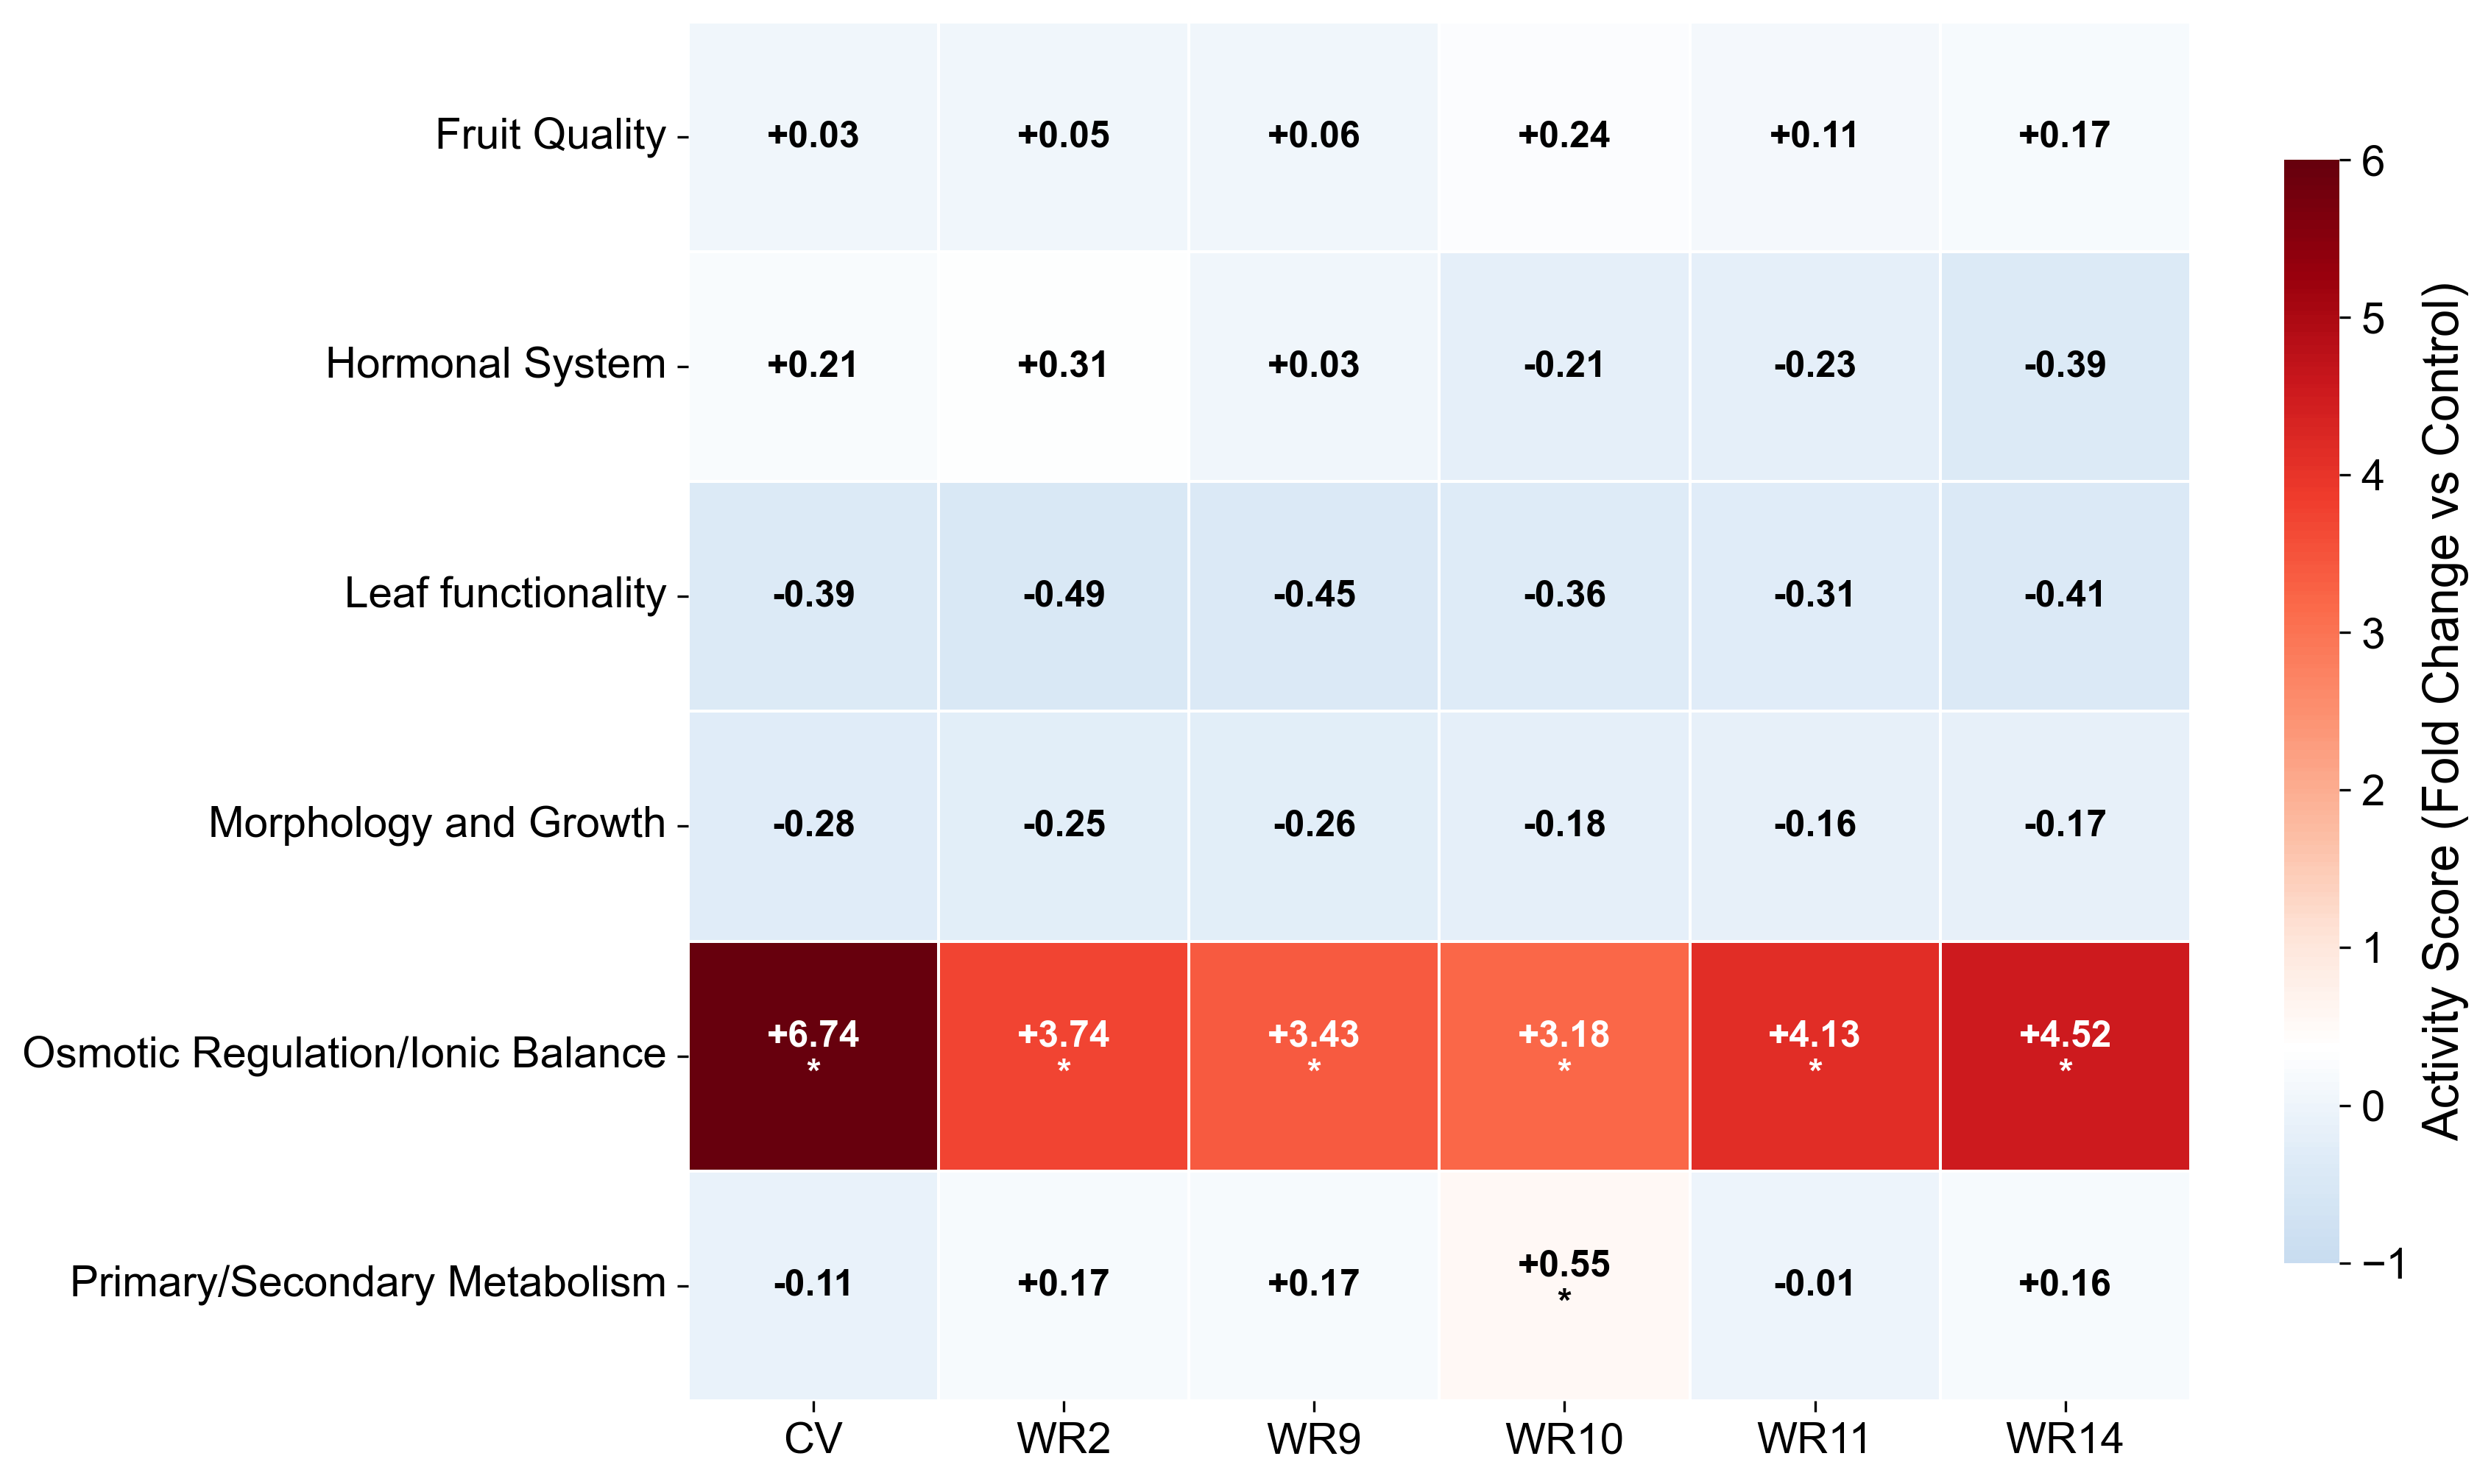


📊 Summary:
  ✓ Figure saved in PNG, SVG, and PDF formats


In [4]:
display(Markdown("### Generating Figure 1..."))

fig1_script = project_root / 'scripts' / 'figure_01_pathway_activity' / 'generate_pathway_heatmap.py'

if fig1_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig1_script)],
        cwd=str(project_root / 'scripts' / 'figure_01_pathway_activity'),
        capture_output=True,
        text=True,
        timeout=120
    )
    
    if result.returncode == 0:
        print("✅ Figure 1 generated successfully!")
        fig_path = project_root / 'scripts' / 'figure_01_pathway_activity' / 'figure_01_pathway_activity_heatmap.png'
        if fig_path.exists():
            display(Image(filename=str(fig_path), width=800))
        # Show output summary
        if result.stdout:
            print("\n📊 Summary:")
            for line in result.stdout.split('\n')[-10:]:
                if line.strip() and ('✅' in line or 'Figure' in line or '✓' in line):
                    print(f"  {line}")
    else:
        print("❌ Error:")
        print(result.stderr[-1000:])

## Figure 2: Adaptive Differences (WR vs CV) by Biological System

> **Dataset:** `data/master_dataset.csv`

**Key Features:**
- Horizontal layout: 6 biological systems as ROWS, parameters as COLUMNS
- **Formula**: (WR_mean - CV_mean) / |CV_mean|
- Color: Blue (CV better) - White (equal) - Red (WR better)
- Range: -1.0 to +1.0
- Significance markers: * (>0.3), ** (>0.5), *** (>1.0)
- All 43 parameters included with real data
- **Parameter acronyms** (22pt bold font) for clarity
- **Horizontal colorbar legend** at bottom showing scale interpretation:
  - Blue side: "CV > WR" 
  - Red side: "WR > CV"

**Biological Systems:**
1. Hormonal system (8 parameters)
2. Primary/secondary metabolism (7 parameters)
3. Osmotic regulation/ionic balance (6 parameters)
4. Leaf functionality (2 parameters)
5. Morphology and growth (11 parameters)
6. Fruit quality (9 parameters)

**Varieties:** WR2, WR9, WR10, WR11, WR14 vs CV

### Generating Figure 2...

✅ Figure 2 generated successfully!


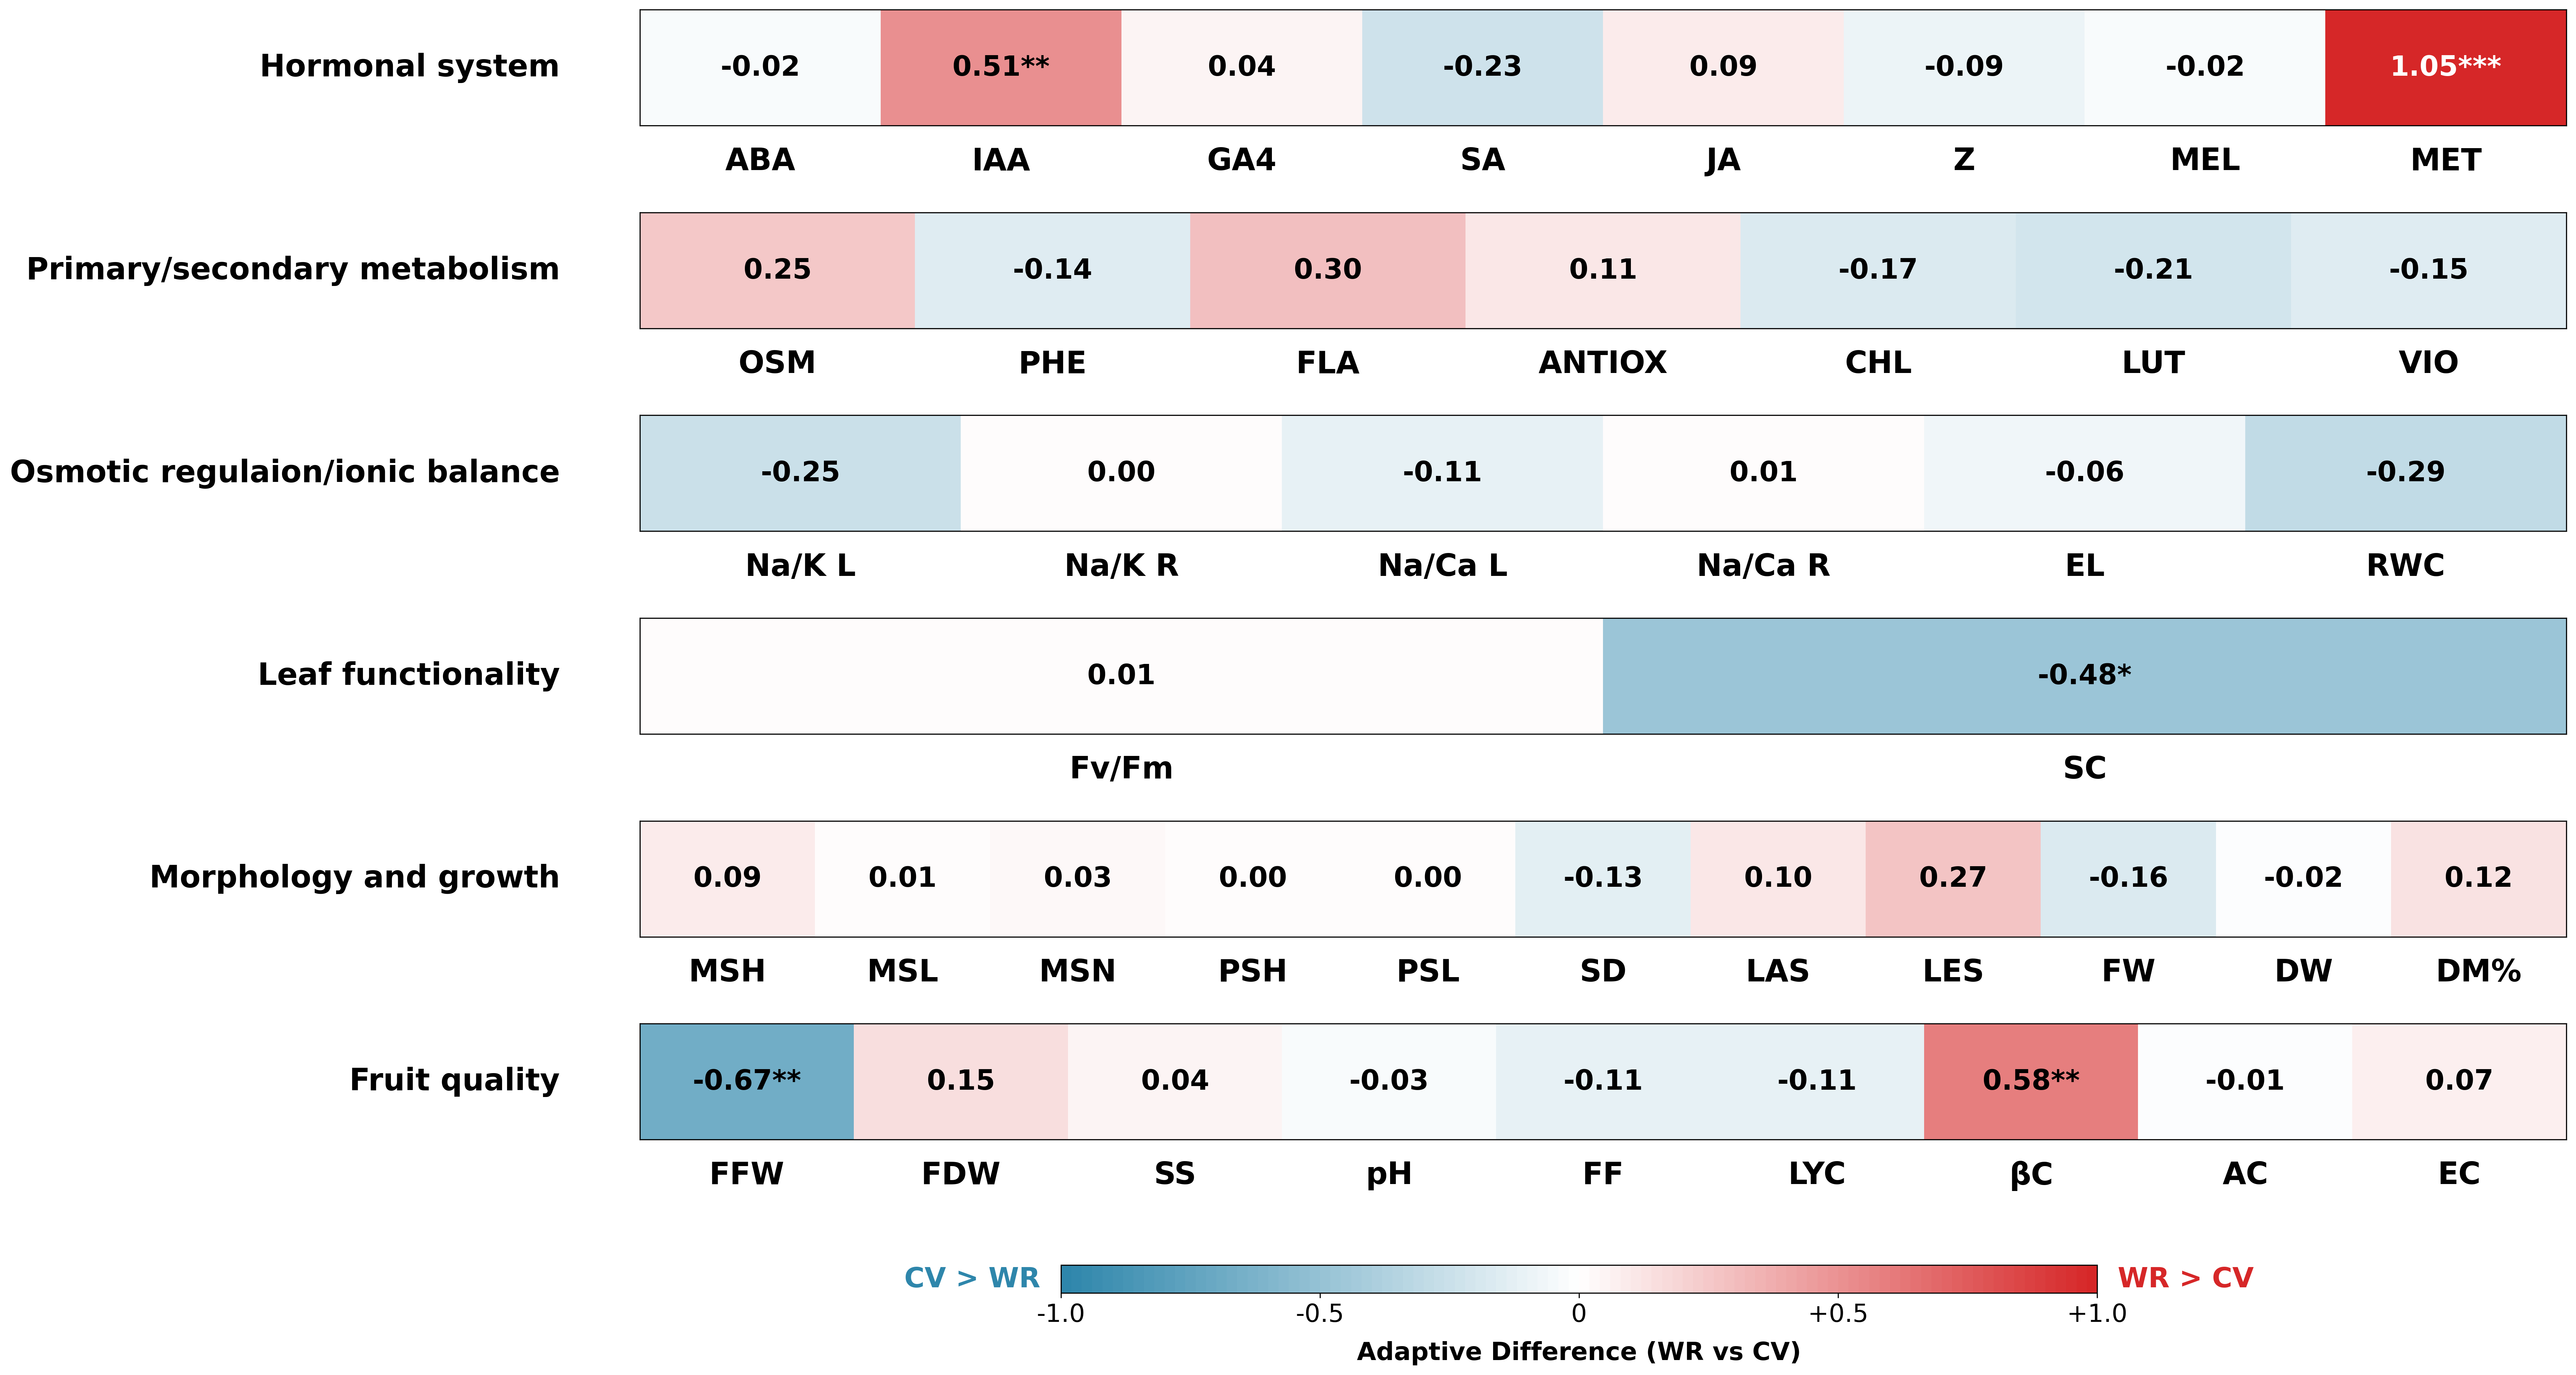


📊 Displayed: figure_02_adaptive_differences.png

Summary:
  ✅ Calculated 43 adaptive differences
  ✅ FIGURE 2 COMPLETED!


In [5]:
display(Markdown("### Generating Figure 2..."))

fig2_script = project_root / 'scripts' / 'figure_02_adaptive_differences' / 'generate_figure_02.py'

if fig2_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig2_script)],
        cwd=str(fig2_script.parent),
        capture_output=True,
        text=True,
        timeout=180
    )
    
    if result.returncode == 0:
        print("✅ Figure 2 generated successfully!")
        
        # Display the generated PNG
        png_file = fig2_script.parent / 'figure_02_adaptive_differences.png'
        if png_file.exists():
            display(Image(filename=str(png_file), width=1200))
            print(f"\n📊 Displayed: {png_file.name}")
            
            # Show summary
            if result.stdout:
                print("\nSummary:")
                for line in result.stdout.split('\n'):
                    if '✅' in line:
                        print(f"  {line}")
        else:
            print(f"⚠️ PNG file not found: {png_file}")
    else:
        print("❌ Error:")
        print(result.stderr[-500:])
else:
    print(f"⚠️ Script not found: {fig2_script}")

## Figure 3: Integrated Multi-Level Biological Network

> **Datasets:** `nodes_unified.csv` and `edges_unified.csv` (derived from primary data)

**Key Features:**
- Multi-level connectivity (Hormonal, Metabolic, Physiological, etc.)
- Dynamic thresholding for positive and negative correlations
- Automatic recalculation of node importance (degree) based on selected filters


In [ ]:
# FIGURE 3: INTEGRATED BIOLOGICAL NETWORK (VERSION 5.1)
import shutil
from IPython.display import display, Image, clear_output, Markdown
import ipywidgets as widgets
import subprocess

# 1. Path configuration
f3_r_script = project_root / "scripts" / "figure_03_network" / "generate_network_PUBLICATION_FINAL.R"
f3_R_COMMAND = shutil.which("Rscript")
f3_exact_path = f3_r_script.parent / "Figure_03_network_EXACT.png"
f3_cross_path = f3_r_script.parent / "Figure_03_network_CROSS_LEVEL_ONLY.png"

# 2. CLEAR ALL PREVIOUS GHOSTS
clear_output(wait=True)

# 3. Helper to generate and display figure
def generate_and_display(p_thr, n_thr, show_intra, show_cross, show_status=True):
    """Generate figure with R and display it."""
    if not f3_R_COMMAND:
        print("⚠️ Rscript not found - cannot generate Figure 3")
        print("   On Colab: Re-run the Setup cell to install R")
        return False
    
    if show_status:
        print(f"⏳ Generating network (thresholds: {p_thr}, {n_thr})...")
    
    result = subprocess.run(
        [f3_R_COMMAND, str(f3_r_script.name), str(p_thr), str(n_thr), 
         str(show_intra).upper(), str(show_cross).upper()],
        cwd=str(f3_r_script.parent),
        capture_output=True,
        text=True,
        timeout=120
    )
    
    if result.returncode != 0:
        print(f"❌ R script error:\n{result.stderr[:800]}")
        return False
    
    # Determine which file to show
    target = f3_exact_path if show_intra or not show_cross else f3_cross_path
    
    if target.exists():
        if show_status:
            print("✅ Generated!")
        display(Image(filename=str(target), width=800))
        return True
    else:
        print(f"❌ Output file not created: {target.name}")
        if result.stdout:
            print(f"R output: {result.stdout[:500]}")
        return False

# 4. DISPLAY STATIC PUBLICATION VERSIONS
display(Markdown("### Standard Publication Versions (Thresholds: 0.35, -0.30)"))

# Generate if needed
if not f3_exact_path.exists():
    display(Markdown("#### A) Full Network (Intra + Cross level)"))
    generate_and_display(0.35, -0.30, True, True)
else:
    display(Markdown("#### A) Full Network (Intra + Cross level)"))
    display(Image(filename=str(f3_exact_path), width=800))

if not f3_cross_path.exists():
    display(Markdown("#### B) Cross-level Only Network"))
    generate_and_display(0.35, -0.30, False, True)
else:
    display(Markdown("#### B) Cross-level Only Network (Filtered for manuscript)"))
    display(Image(filename=str(f3_cross_path), width=800))

display(Markdown("---"))
display(Markdown("### Interactive Exploration Area"))

# 5. INTERACTIVE LOGIC
def run_interactive_f3():
    if not f3_R_COMMAND:
        print("⚠️ Rscript not found - interactive mode disabled.")
        print("   On Colab: Re-run the Setup cell to install R")
        return

    # Widgets
    w_pos = widgets.FloatSlider(value=0.35, min=0.1, max=0.9, step=0.05, description="Pos r ≥:")
    w_neg = widgets.FloatSlider(value=-0.30, min=-0.9, max=-0.1, step=0.05, description="Neg r ≤:")
    w_intra = widgets.Checkbox(value=True, description="Show Intra-level")
    w_cross = widgets.Checkbox(value=True, description="Show Cross-level")
    w_btn = widgets.Button(description="Generate Figure", button_style="primary")
    
    # Isolated output for the interactive result
    w_out = widgets.Output()
    
    def on_click(b):
        with w_out:
            clear_output(wait=True)
            b.disabled = True
            b.description = "⏳ Processing..."
            try:
                display(Markdown(f"**Dynamic Result:** (r ≥ {w_pos.value} / r ≤ {w_neg.value})"))
                generate_and_display(w_pos.value, w_neg.value, w_intra.value, w_cross.value, show_status=False)
            finally:
                b.disabled = False
                b.description = "Generate Figure"
    
    w_btn.on_click(on_click)
    display(widgets.VBox([widgets.HBox([w_pos, w_neg]), widgets.HBox([w_intra, w_cross]), w_btn]), w_out)

run_interactive_f3()


## Figure 4: Phenological Timing Analysis (GDD-Based)

> **Dataset:** `data/master_dataset.csv`

**Part a:** GDD Cumulative Heatmap
- Y-axis: 18 variety-treatment combinations (6 varieties × 3 treatments)
- X-axis: 4 phenological phases (Vegetative, Flowering, Fruit set, Fruit ripening)
- Color: Yellow-Orange-Red gradient (YlOrRd)
- Values: Cumulative GDD shown inside cells
- Range: 250-950 GDD
- White separation lines between rows

**Part b:** Phenological Delay Scatter Plot
- X-axis: Delay (%) relative to control
- Y-axis: Indexed positions (0-12)
- Points colored by treatment (S1=orange, S2=red)
- Labels positioned next to points
- Reference line at x=0

**Data Source:** Real phenological data from master_dataset.csv

### Generating Figure 4...

✅ Figure 4 generated successfully!


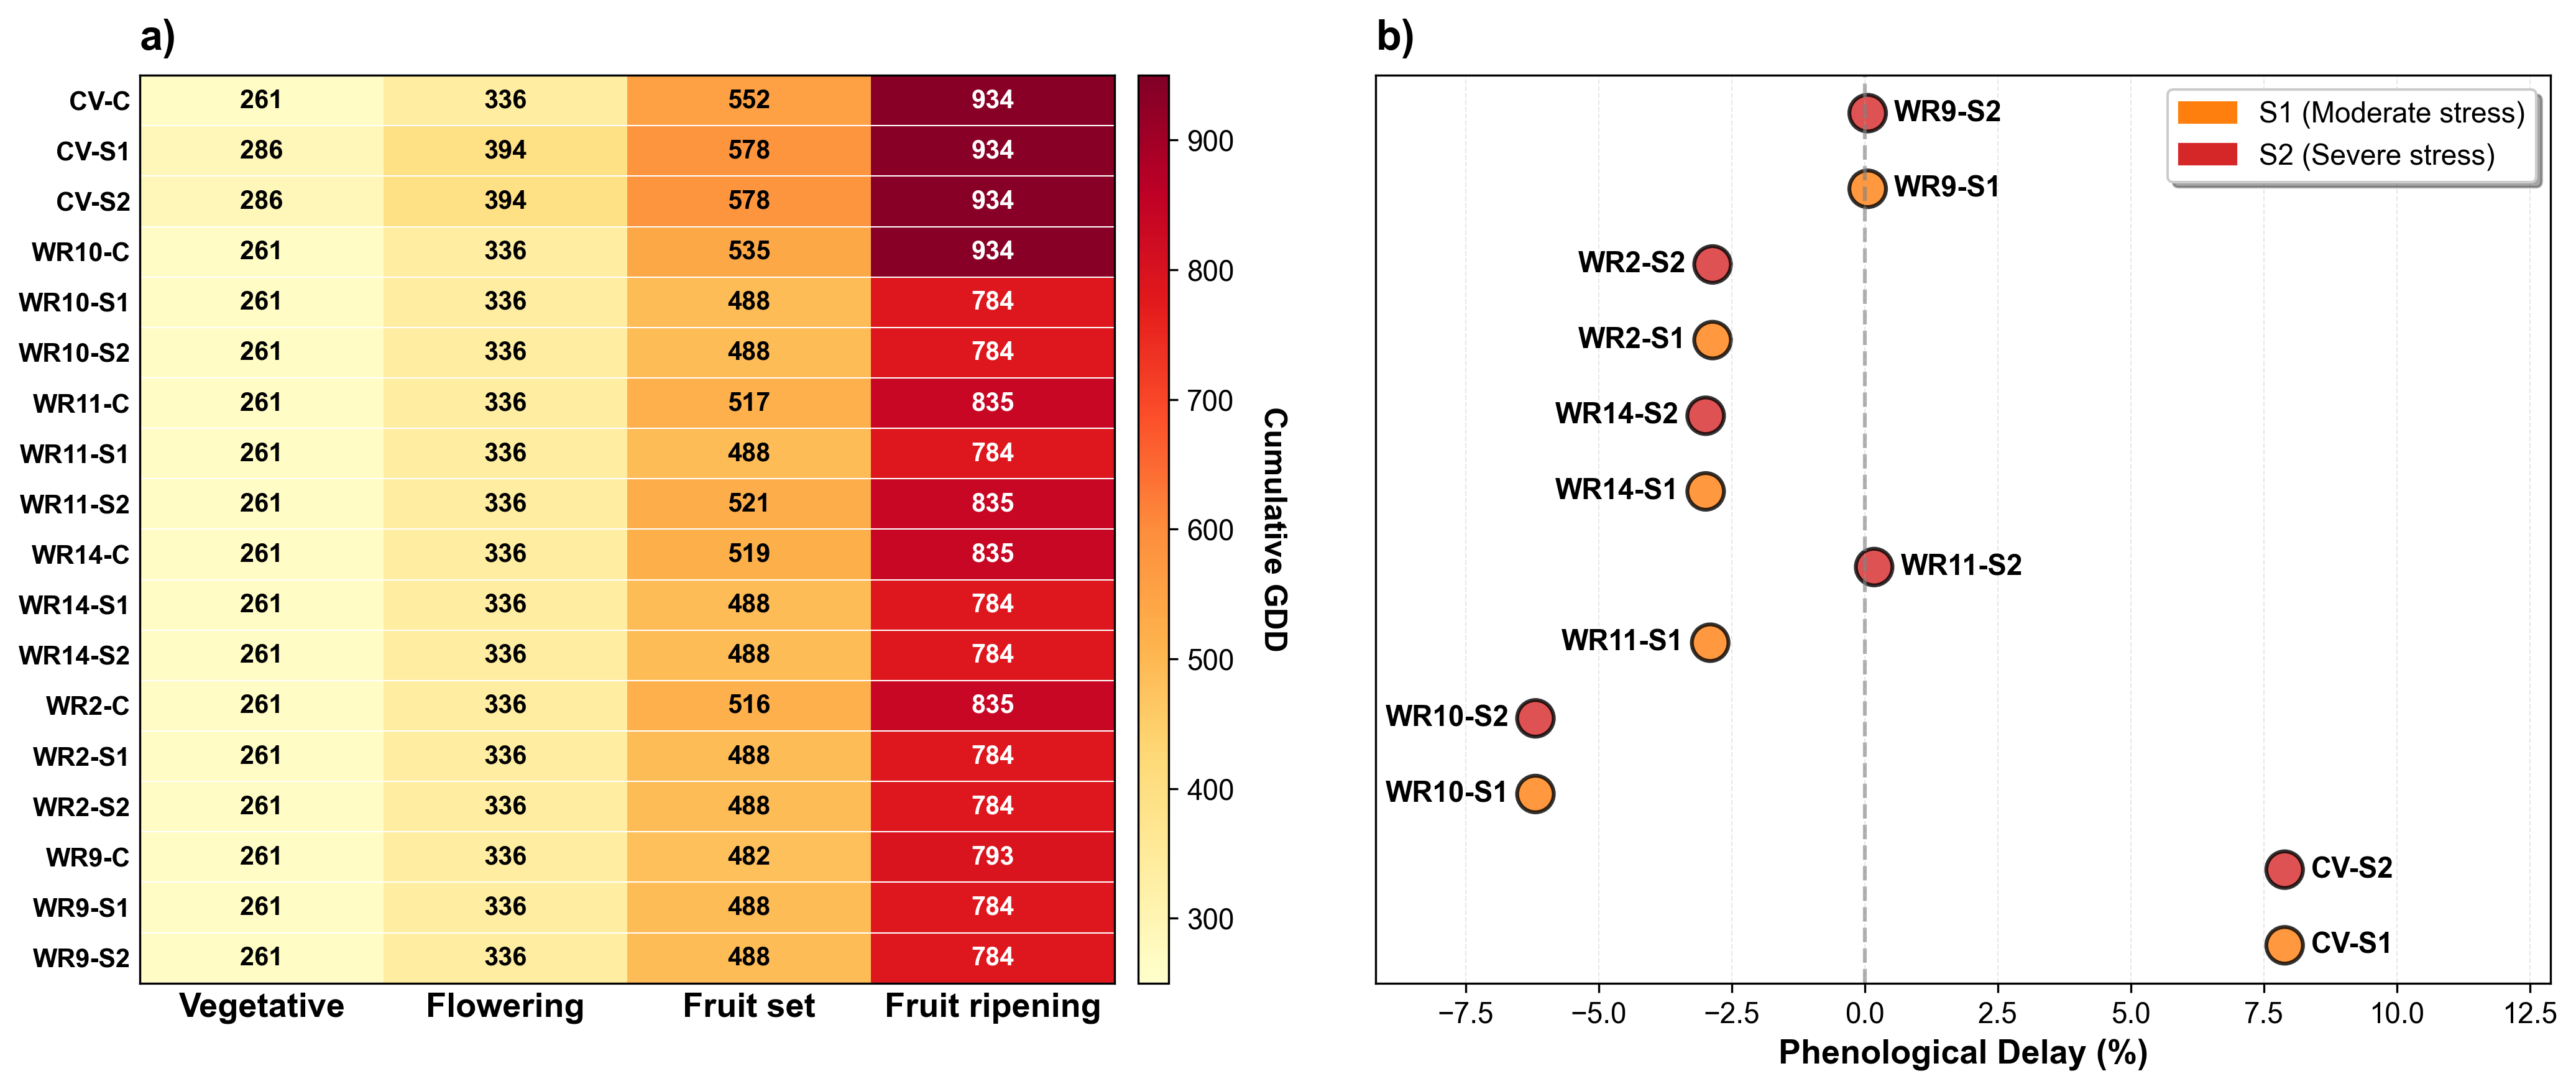


📊 Displayed: figure_04_phenological_timing.png

Summary:
  ✓ Master dataset loaded: 1173 rows
     ✓ Data loaded for 6 varieties
     ✓ Effects calculated for 6 varieties
  ✅ PNG: /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/scripts/figure_04_phenological_timing/figure_04_phenological_timing.png
  ✅ PDF: /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/scripts/figure_04_phenological_timing/figure_04_phenological_timing.pdf
  ✅ COMPLETED!


In [7]:
display(Markdown("### Generating Figure 4..."))

fig4_script = project_root / 'scripts' / 'figure_04_phenological_timing' / 'generate_figure_04.py'

if fig4_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig4_script)],
        cwd=fig4_script.parent,
        capture_output=True,
        text=True,
        timeout=180
    )
    
    if result.returncode == 0:
        print("✅ Figure 4 generated successfully!")
        
        png_file = fig4_script.parent / 'figure_04_phenological_timing.png'
        if png_file.exists():
            display(Image(filename=str(png_file), width=1000))
            print(f"\n📊 Displayed: {png_file.name}")
            
            # Show summary
            if result.stdout:
                print("\nSummary:")
                for line in result.stdout.split('\n'):
                    if '✓' in line or '✅' in line:
                        print(f"  {line}")
    else:
        print("❌ Error:")
        print(result.stderr[-500:])
else:
    print(f"⚠️ Script not found: {fig4_script}")

## Figure 5: Temporal Dynamics of Phenological Development

> **Dataset:** `data/master_dataset.csv`

**Key Features:**
- 12-panel figure (4 rows × 3 columns)
- X-axis: DAT (Days After Transplant) - **global limit 0-103** based on maximum DAT across all data (98)
- Three treatment conditions per metric (Control, Moderate stress, Severe stress)
- 6 varieties per panel with distinct colors
- Line plots with shaded error bands (mean ± SE)
- **Data source**: Uses raw replicates data (`raw_replicates_phenological.csv`) for complete temporal coverage
- **Significance asterisks BELOW X-axis** (colored by variety) indicating WR varieties significantly different from CV
- **Uniform Y-scale** per metric row (same limits across treatments)
- **Y-axis labels** only in first column (cleaner layout)
- **Legend** only in first row (panels a, b, c)
- **Missing data handling**: NaN values at DAT 56, 66, 71 for "Trusses maturing" (when no ripe fruits were recorded) are interpreted as 0 for continuity

**DAT 98 exclusion logic:**
- **Main shoot height & Flowering**: Include DAT 98 (valid growth/flowering data)
- **Fruit set & Fruit ripening**: Exclude DAT 98 (values return to 0 after destructive sampling at DAT 77)

**Font sizes (increased for publication):**
- X-axis label (DAT): 20pt bold
- Y-axis labels: 18pt bold
- Panel titles (a, b, c...): 20pt bold
- Treatment column titles: 22pt bold
- Tick labels: 16pt
- Legend: 18pt

**Panels:**
- **a-c:** Main shoot height (cm) - continuous growth, data through DAT 98
- **d-f:** Flowering (trusses number) - continuous accumulation, data through DAT 98
- **g-i:** Fruit set (trusses number) - peak at DAT 77, DAT 98 excluded
- **l-n:** Fruit ripening (trusses number) - continuous from 0, peak at DAT 77, DAT 98 excluded

**Variety Colors:**
- CV: Black (thicker line, 3.5pt) - Reference
- WR2: Red (asterisks row 1)
- WR9: Cyan (asterisks row 2)
- WR10: Green (asterisks row 3)
- WR11: Goldenrod (asterisks row 4)
- WR14: Purple (asterisks row 5)

**Statistics:** Welch's t-test (WR vs CV) with Bonferroni correction (×5)
- Asterisks positioned below X-axis in dedicated rows per variety
- Each variety's asterisks appear in its own row, colored to match the line
- Significance levels: * p<0.05, ** p<0.01, *** p<0.001

### Generating Figure 5...

✅ Figure 5 generated successfully!


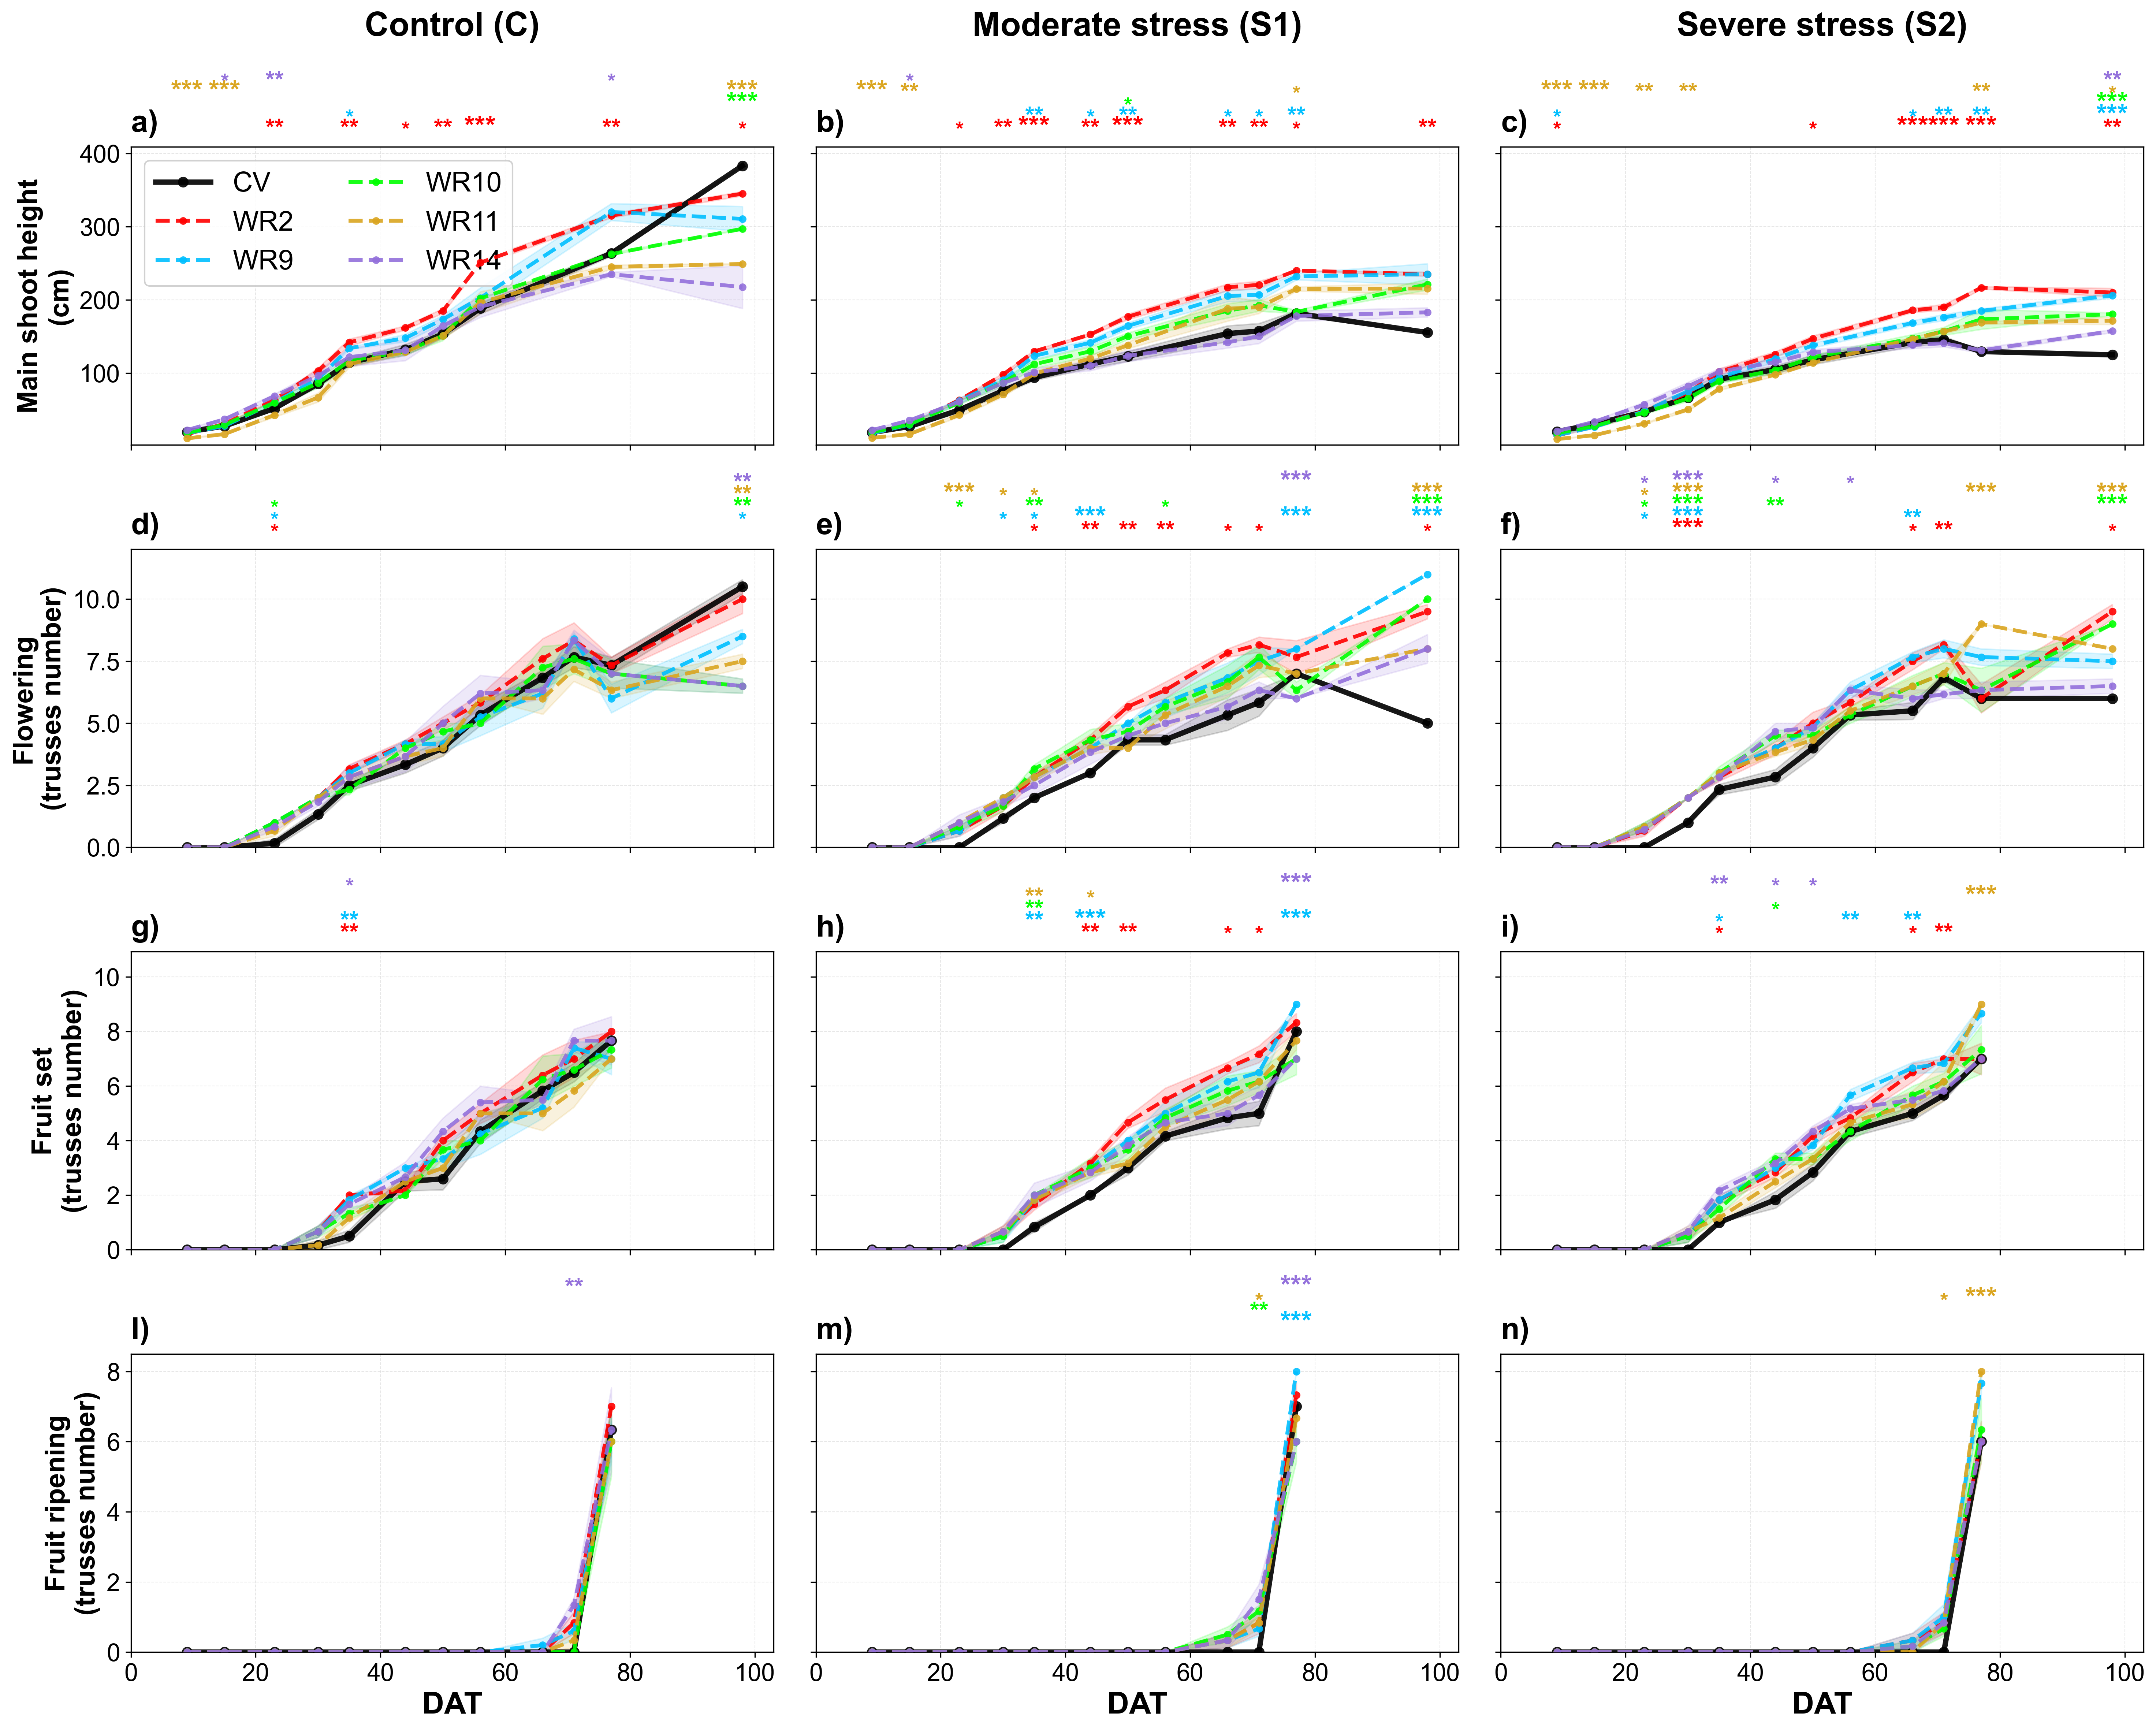


📊 Displayed: figure_05_temporal_dynamics.png

Summary:
  ✅ PNG: /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/scripts/figure_05_temporal_dynamics/figure_05_temporal_dynamics.png


In [8]:
display(Markdown("### Generating Figure 5..."))

fig5_script = project_root / 'scripts' / 'figure_05_temporal_dynamics' / 'generate_figure_05.py'

if fig5_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig5_script)],
        cwd=fig5_script.parent,
        capture_output=True,
        text=True,
        timeout=300
    )
    
    if result.returncode == 0:
        print("✅ Figure 5 generated successfully!")
        
        png_file = fig5_script.parent / 'figure_05_temporal_dynamics.png'
        if png_file.exists():
            display(Image(filename=str(png_file), width=1400))
            print(f"\n📊 Displayed: {png_file.name}")
            
            # Show summary
            if result.stdout:
                print("\nSummary:")
                for line in result.stdout.split('\n'):
                    if '✅' in line and 'PNG' in line:
                        print(f"  {line}")
    else:
        print("❌ Error:")
        print(result.stderr[-500:])
else:
    print(f"⚠️ Script not found: {fig5_script}")

## Figure 6: Variety Ranking and Category Contribution

> **Dataset:** `data/master_dataset.csv`

**Panel a:** Final Stress Tolerance Ranking - Simple horizontal bars with total scores  
**Panel b:** Category Contribution - Stacked bars (Performance/Maintenance/Physiological/Stress Marker)

**Modifications:**
- X-axis label: "Score" (not "Punteggio Composito")
- Variety colors consistent with Figure 5: CV=black, WR2=red, WR9=cyan, WR10=green, WR11=goldenrod (#DAA520), WR14=purple
- Legend font size increased to 16pt
- Horizontal legend at bottom

**Data Source:** Calculated from real dataset (master_dataset.csv)

### Generating Figure 6...

✅ Figure 6 generated successfully!
   Data: CALCULATED from real dataset


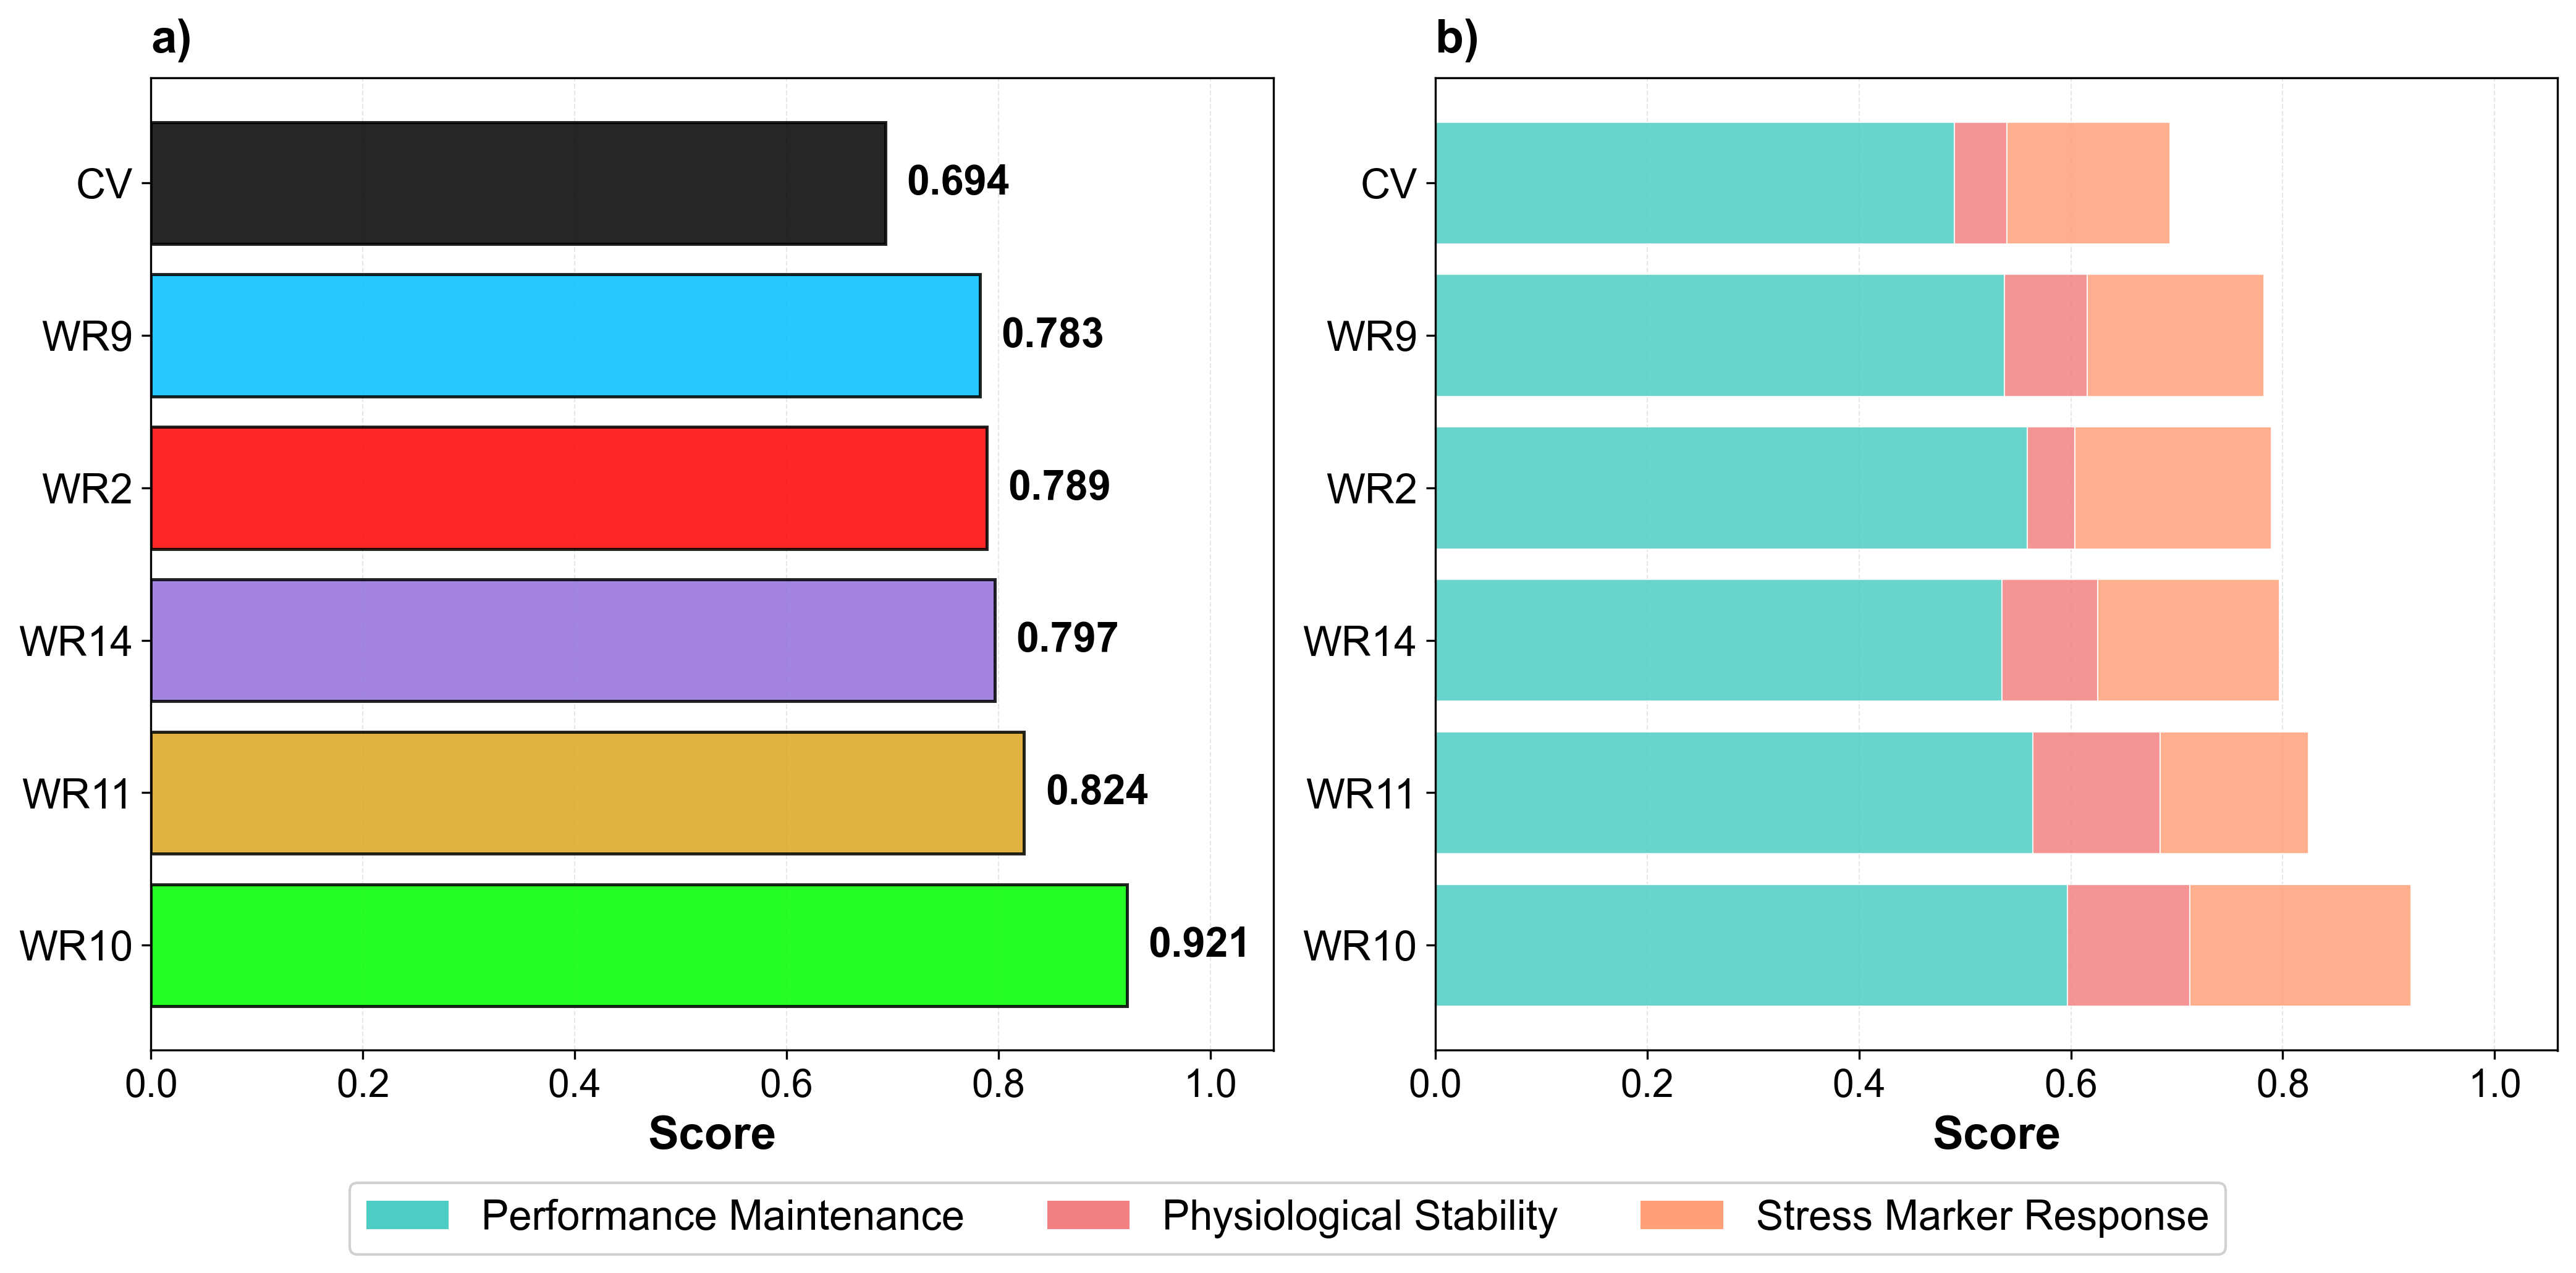


📊 Displayed: figure_06_variety_ranking.png

Ranking calculated:
      TOTALE: 0.694
      TOTALE: 0.789
      TOTALE: 0.783
      TOTALE: 0.921
      TOTALE: 0.824
      TOTALE: 0.797


In [9]:
display(Markdown("### Generating Figure 6..."))

fig6_script = project_root / "scripts" / "figure_06_variety_ranking" / "generate_figure_06.py"

if fig6_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig6_script)],
        cwd=fig6_script.parent,
        capture_output=True,
        text=True,
        timeout=180
    )
    
    if result.returncode == 0:
        print("✅ Figure 6 generated successfully!")
        print("   Data: CALCULATED from real dataset")
        
        png_file = fig6_script.parent / "figure_06_variety_ranking.png"
        if png_file.exists():
            display(Image(filename=str(png_file), width=1000))
            print(f"\n📊 Displayed: {png_file.name}")
            
            # Show ranking
            if result.stdout:
                print("\nRanking calculated:")
                for line in result.stdout.split("\n"):
                    if "TOTALE:" in line:
                        print(f"  {line}")
    else:
        print("❌ Error:")
        print(result.stderr[-500:])
else:
    print(f"⚠️ Script not found: {fig6_script}")

## Figure 7: Parameter Responsiveness Heatmap by Category

> **Dataset:** `data/parameter_ranking_unified.csv` (derived from primary data)

**Key Features:**
- Two-panel figure: WR10 (best wild) and CV (cultivated)
- Parameters grouped by category (Performance, Stability, Stress Marker)
- Normalized scores (0-100) based on F-statistic, Eta-squared, and % Change

### Generating Figure 7...

✅ Figure 7 generated successfully!


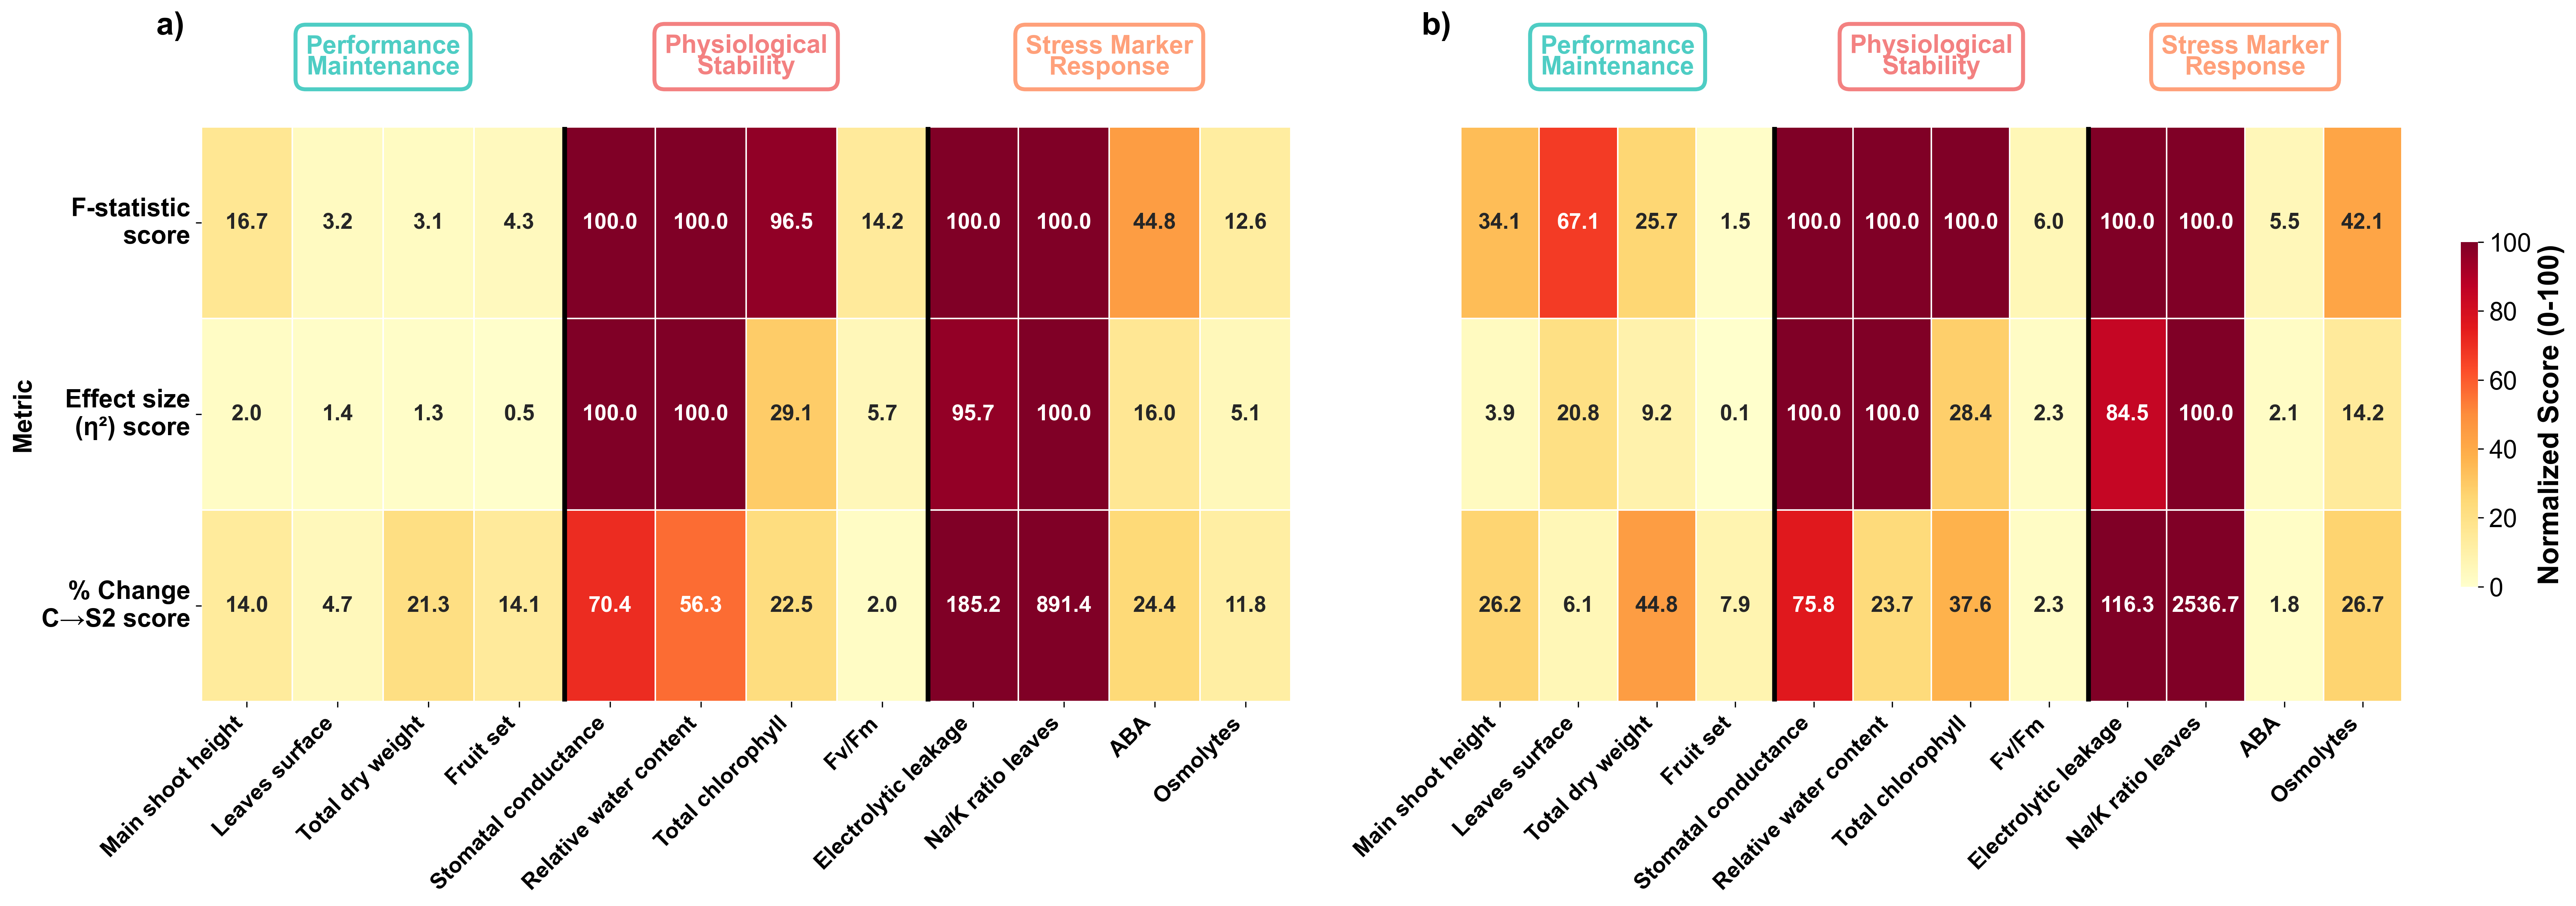


📊 Displayed: figure_07_parameter_responsiveness.png


In [10]:
display(Markdown("### Generating Figure 7..."))

fig7_script = project_root / "scripts" / "figure_07_responsiveness" / "generate_figure_07.py"

if fig7_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig7_script)],
        cwd=fig7_script.parent,
        capture_output=True,
        text=True,
        timeout=180
    )
    
    if result.returncode == 0:
        print("✅ Figure 7 generated successfully!")
        
        png_file = fig7_script.parent / "figure_07_parameter_responsiveness.png"
        if png_file.exists():
            display(Image(filename=str(png_file), width=1400))
            print(f"\n📊 Displayed: {png_file.name}")
    else:
        print("❌ Error:")
        print(result.stderr[-500:])
else:
    print(f"⚠️ Script not found: {fig7_script}")

## Figure 8: Regression Comparison (WR10 vs CV)

> **Dataset:** `data/master_dataset.csv`

**Key Features:**
- 3-panel comparison showing dose-response relationships
- Linear regression (panels a, b) and exponential regression (panel c)
- WR10 (S. pimpinellifolium) vs CV (S. lycopersicum)
- Salinity gradient: Control (3.22 mS/cm), S1 (11.0 mS/cm), S2 (21.0 mS/cm)

**Panels:**
- **a)** Main Shoot Height (cm) - Performance Maintenance
- **b)** Stomatal Conductance (% of control) - Physiological Stability  
- **c)** Electrolytic Leakage (µS/cm) - Stress Marker Response

**Statistics:** 
- R² values for model fit quality
- Confidence intervals shown as shaded regions
- Category colors match Figure 7: Cyan, Pink, Orange

**Data Source:** Real physiological data from master_dataset.csv

### Generating Figure 8...

✅ Figure 8 generated successfully!


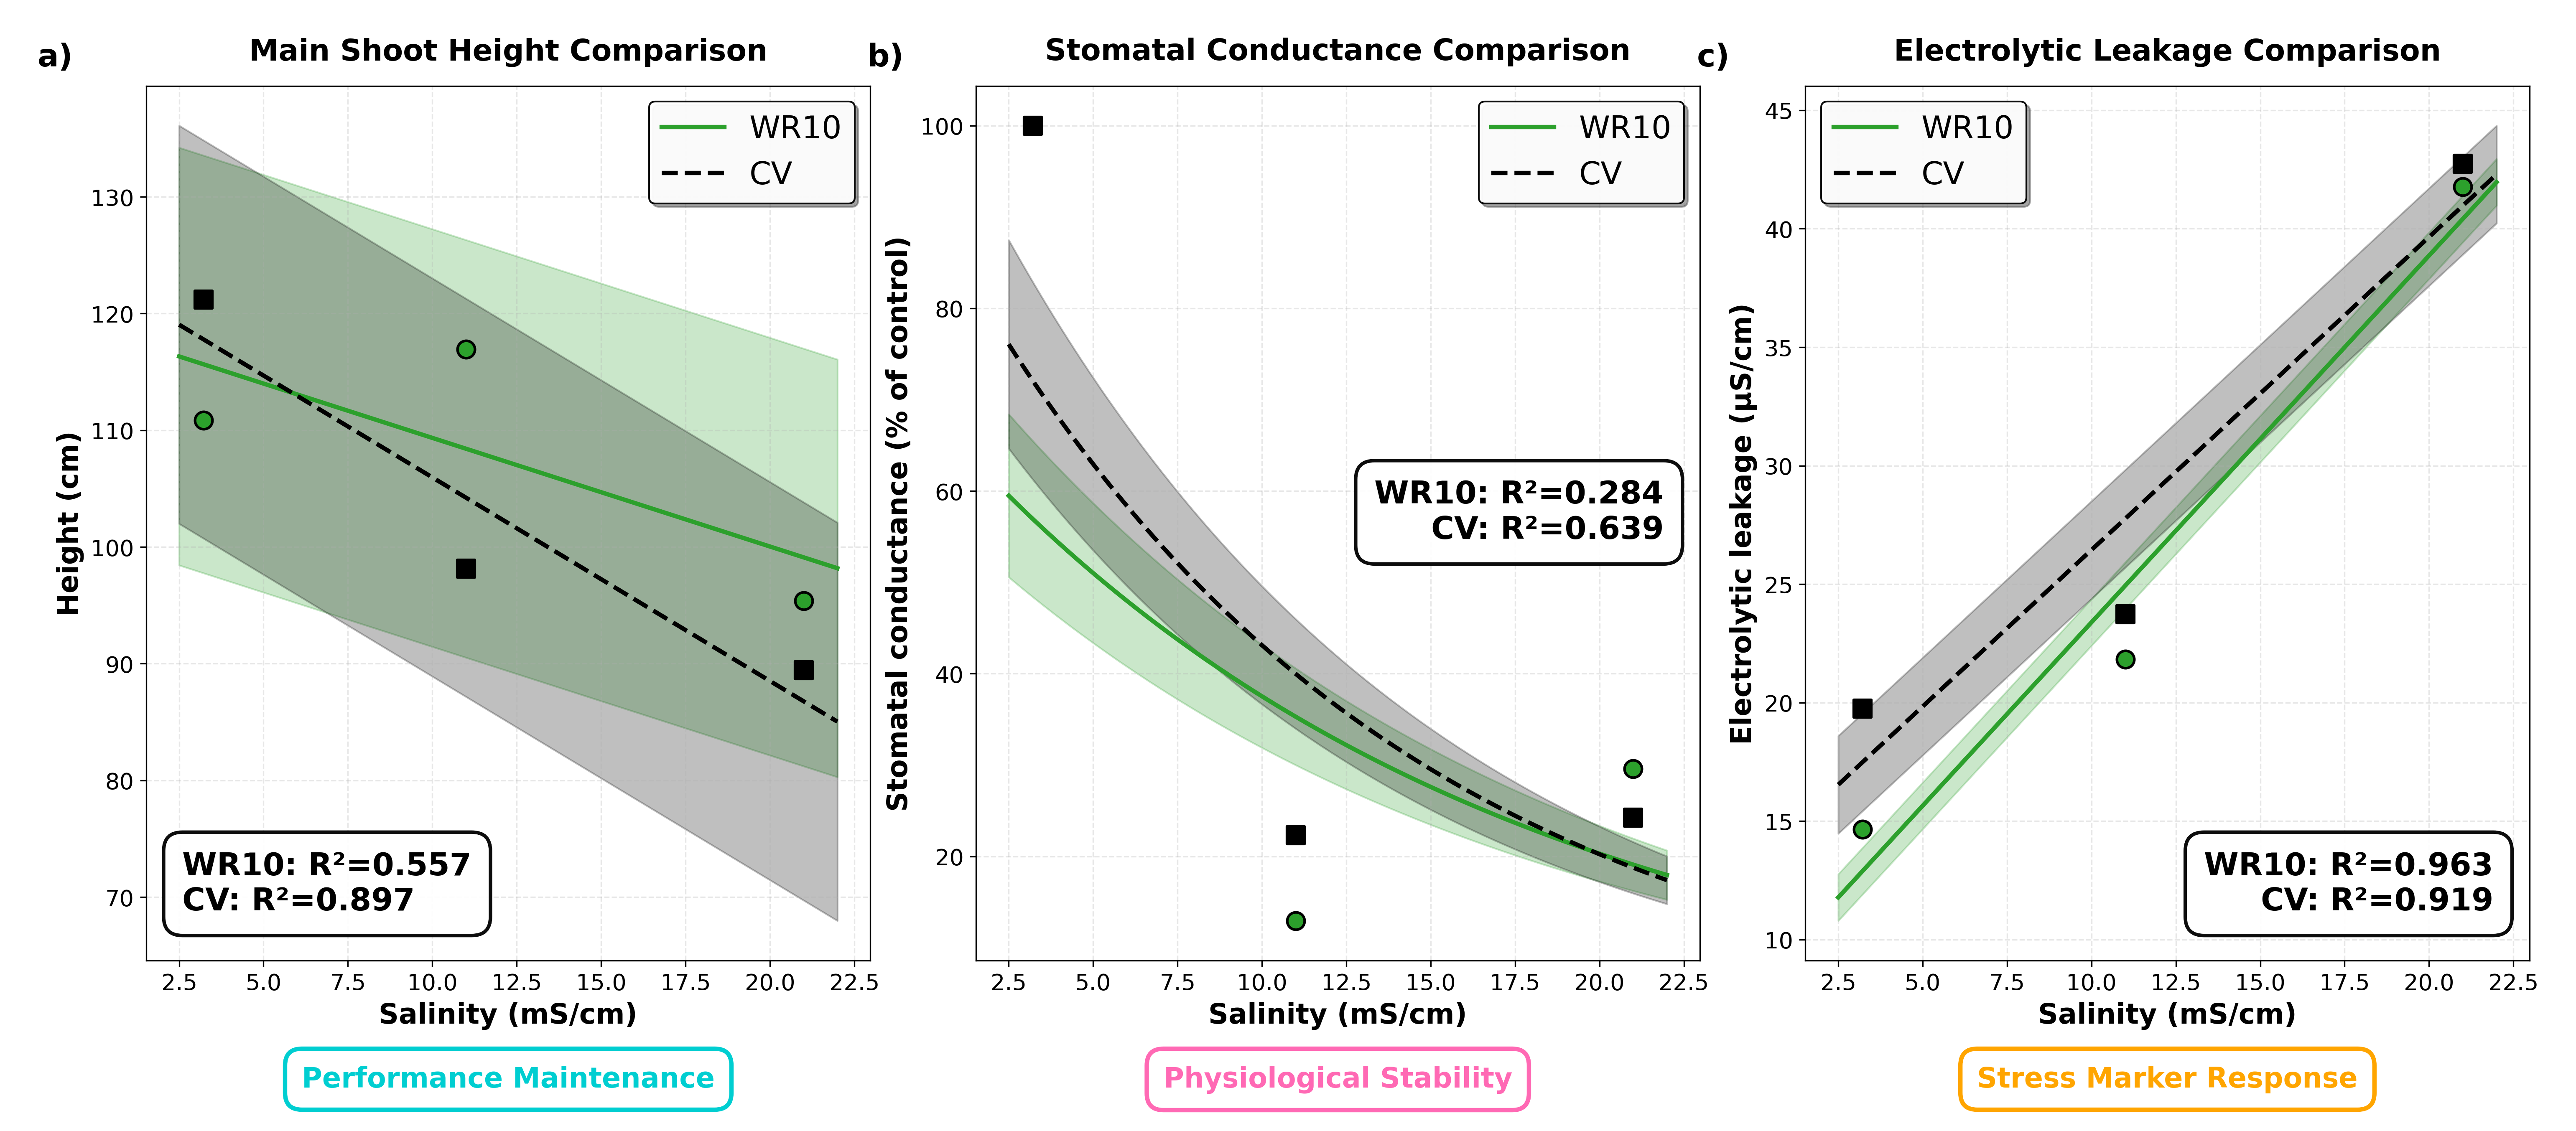


📊 Displayed: figure_08_regression_comparison.png


In [11]:
display(Markdown("### Generating Figure 8..."))

fig8_script = project_root / 'scripts' / 'figure_08_regression_comparison' / 'generate_figure_08.py'

if fig8_script.exists():
    result = subprocess.run(
        [sys.executable, str(fig8_script)],
        cwd=fig8_script.parent,
        capture_output=True,
        text=True,
        timeout=180
    )
    
    if result.returncode == 0:
        print("✅ Figure 8 generated successfully!")
        
        png_file = fig8_script.parent / 'figure_08_regression_comparison.png'
        if png_file.exists():
            display(Image(filename=str(png_file), width=1000))
            print(f"\n📊 Displayed: {png_file.name}")
    else:
        print("❌ Error:")
        print(result.stderr[-500:])

## Manuscript Figures Summary

All 8 manuscript figures have been successfully generated from the **single unified master dataset**.

### Key Reproducibility Features:
- ✅ **Single Source of Truth**: All analyses start from `data/master_dataset.csv`.
- ✅ **Integrated Replicates**: Scripts for Figures 4 and 5 utilize raw replicates for error calculation and testing directly from the master file.
- ✅ **Automatic Consistency**: Figures 1, 3, and 7 use intermediate data derived dynamically from the same source.
- ✅ **Human Inspection**: A simplified summary dataset is generated on-the-fly for quick validation.
- ✅ **Verification**: All statistical methods (Welch's t-tests, Bonferroni corrections) are applied consistently across genotypes.

---

# Supplementary Materials

The following section generates supplementary figures and tables:

| Item | Description | Content |
|------|-------------|---------|  
| **Fig. S1** | Osmotic Regulation/Ionic Balance | Pathway activity heatmap |
| **Fig. S2** | Primary/Secondary Metabolism | Pathway activity heatmap |
| **Fig. S3** | Hormonal System | Pathway activity heatmap |
| **Fig. S4** | Morphology and Growth | Pathway activity heatmap |
| **Fig. S5** | Fruit Quality | Pathway activity heatmap |
| **Fig. S6** | Leaf Functionality | Pathway activity heatmap |
| **Tab. S2** | Parameter Scores for CV and WR10 | Salt-tolerance ranking metrics |

In [12]:
# Supplementary Materials Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Output directory for supplementary figures
sm_output_dir = project_root / 'scripts' / 'supplementary_figures'
sm_output_dir.mkdir(parents=True, exist_ok=True)

# Load master dataset
sm_data_path = project_root / 'data' / 'master_dataset.csv'
df_sm = pd.read_csv(sm_data_path)
print(f"Dataset loaded for SM: {len(df_sm)} rows, {len(df_sm.columns)} columns")

VARIETIES = ['CV', 'WR2', 'WR9', 'WR10', 'WR11', 'WR14']

def calculate_activity_score(df, param, variety):
    """Calculate Activity Score (Fold Change vs Control)"""
    control_data = df[(df['Treatment'] == 'C') & (df['Variety'] == variety)][param].dropna()
    stress_data = df[(df['Treatment'] == 'S2') & (df['Variety'] == variety)][param].dropna()
    if len(control_data) == 0 or len(stress_data) == 0:
        return np.nan
    control_mean = control_data.mean()
    stress_mean = stress_data.mean()
    if control_mean == 0:
        return np.nan
    return (stress_mean - control_mean) / control_mean

def calculate_significance(df, param, variety):
    """Calculate statistical significance using Welch's t-test"""
    control_data = df[(df['Treatment'] == 'C') & (df['Variety'] == variety)][param].dropna()
    stress_data = df[(df['Treatment'] == 'S2') & (df['Variety'] == variety)][param].dropna()
    if len(control_data) < 2 or len(stress_data) < 2:
        return np.nan, ''
    try:
        t_stat, p_value = stats.ttest_ind(control_data, stress_data, equal_var=False)
        if p_value < 0.001:
            sig = '***'
        elif p_value < 0.01:
            sig = '**'
        elif p_value < 0.05:
            sig = '*'
        else:
            sig = ''
        return p_value, sig
    except:
        return np.nan, ''

def create_heatmap_data(df, params):
    """Create matrix for heatmap: parameters (rows) x varieties (columns)"""
    data_matrix = []
    sig_matrix = []
    for param in params:
        row_data = []
        row_sig = []
        for variety in VARIETIES:
            score = calculate_activity_score(df, param, variety)
            p_val, sig = calculate_significance(df, param, variety)
            row_data.append(score)
            row_sig.append(sig)
        data_matrix.append(row_data)
        sig_matrix.append(row_sig)
    return np.array(data_matrix), sig_matrix

def plot_sm_heatmap(data_matrix, sig_matrix, params, title, vmin=-3, vmax=3, text_threshold=1.5):
    """Plot heatmap with activity scores and significance asterisks"""
    fig, ax = plt.subplots(figsize=(10, max(6, len(params) * 0.8)))
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    im = ax.imshow(data_matrix, cmap=cmap, aspect='auto', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02)
    cbar.set_label('Activity Score (Fold Change vs Control)', fontsize=11, fontweight='bold')
    ax.set_xticks(range(len(VARIETIES)))
    ax.set_xticklabels(VARIETIES, fontsize=12, fontweight='bold')
    ax.set_yticks(range(len(params)))
    ax.set_yticklabels(params, fontsize=11)
    for i in range(len(params)):
        for j in range(len(VARIETIES)):
            value = data_matrix[i, j]
            sig = sig_matrix[i][j]
            if np.isnan(value):
                text = 'N/A'
            else:
                text = f'{value:.2f}'
                if sig:
                    text = f'{value:.2f}\n{sig}'
            text_color = 'white' if abs(value) > text_threshold else 'black'
            ax.text(j, i, text, ha='center', va='center', fontsize=10, fontweight='bold', color=text_color)
    for i in range(len(params) + 1):
        ax.axhline(i - 0.5, color='white', linewidth=0.5)
    for j in range(len(VARIETIES) + 1):
        ax.axvline(j - 0.5, color='white', linewidth=0.5)
    ax.tick_params(length=0)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    return fig

print("SM functions defined successfully!")

Dataset loaded for SM: 1173 rows, 69 columns
SM functions defined successfully!


## Figure S1: Osmotic Regulation/Ionic Balance

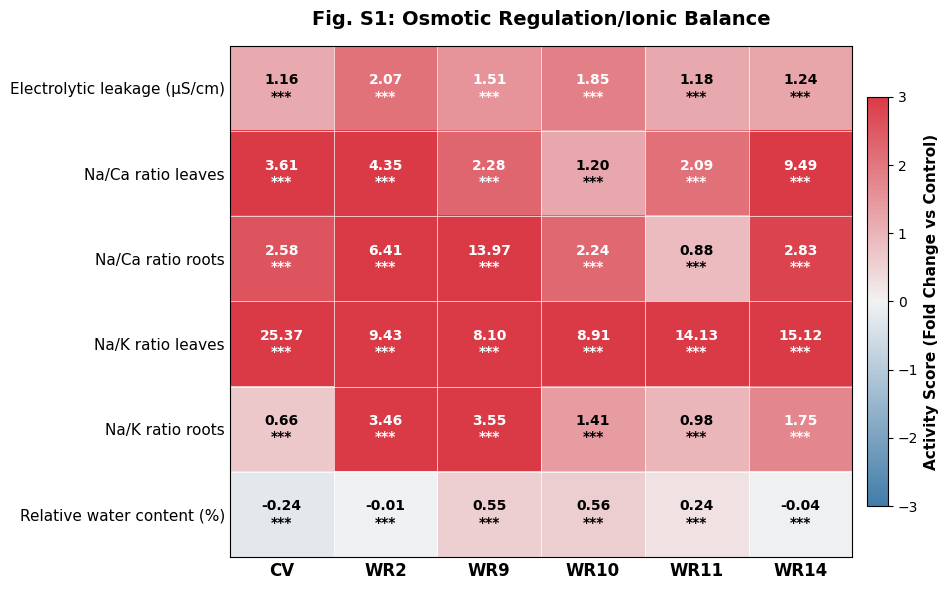

✅ Figure S1 saved!


In [13]:
S1_PARAMS = [
    'Electrolytic leakage (μS/cm)',
    'Na/Ca ratio leaves',
    'Na/Ca ratio roots',
    'Na/K ratio leaves',
    'Na/K ratio roots',
    'Relative water content (%)'
]

data_S1, sig_S1 = create_heatmap_data(df_sm, S1_PARAMS)
fig_S1 = plot_sm_heatmap(data_S1, sig_S1, S1_PARAMS, 
                         'Fig. S1: Osmotic Regulation/Ionic Balance',
                         vmin=-3, vmax=3, text_threshold=1.5)
plt.show()
fig_S1.savefig(sm_output_dir / 'figure_S1_osmotic_regulation.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Figure S1 saved!")

## Figure S2: Primary/Secondary Metabolism

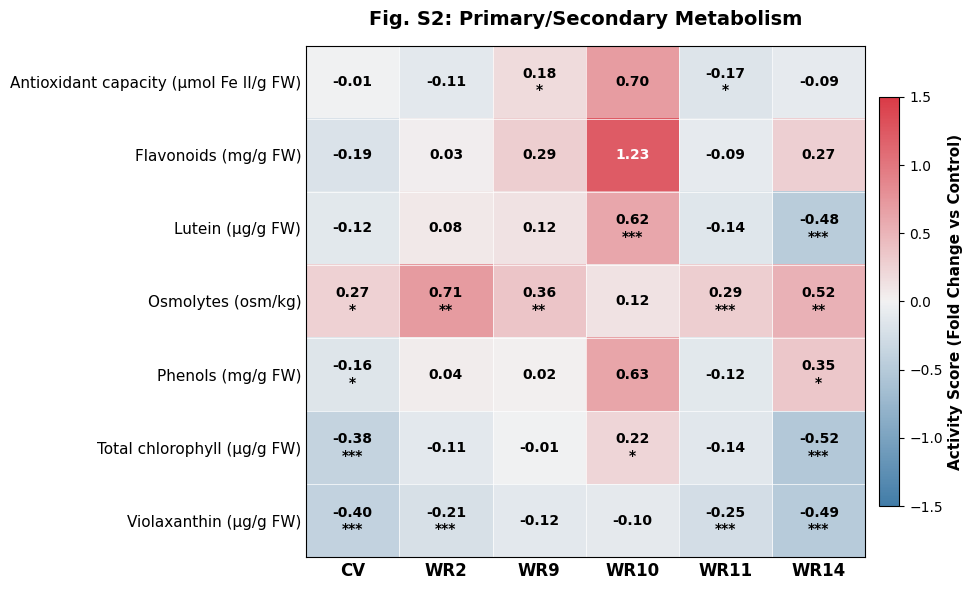

✅ Figure S2 saved!


In [14]:
S2_PARAMS = [
    'Antioxidant capacity (μmol Fe II/g FW)',
    'Flavonoids (mg/g FW)',
    'Lutein (μg/g FW)',
    'Osmolytes (osm/kg)',
    'Phenols (mg/g FW)',
    'Total chlorophyll (μg/g FW)',
    'Violaxanthin (μg/g FW)'
]

data_S2, sig_S2 = create_heatmap_data(df_sm, S2_PARAMS)
fig_S2 = plot_sm_heatmap(data_S2, sig_S2, S2_PARAMS, 
                         'Fig. S2: Primary/Secondary Metabolism',
                         vmin=-1.5, vmax=1.5, text_threshold=0.8)
plt.show()
fig_S2.savefig(sm_output_dir / 'figure_S2_metabolism.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Figure S2 saved!")

## Figure S3: Hormonal System

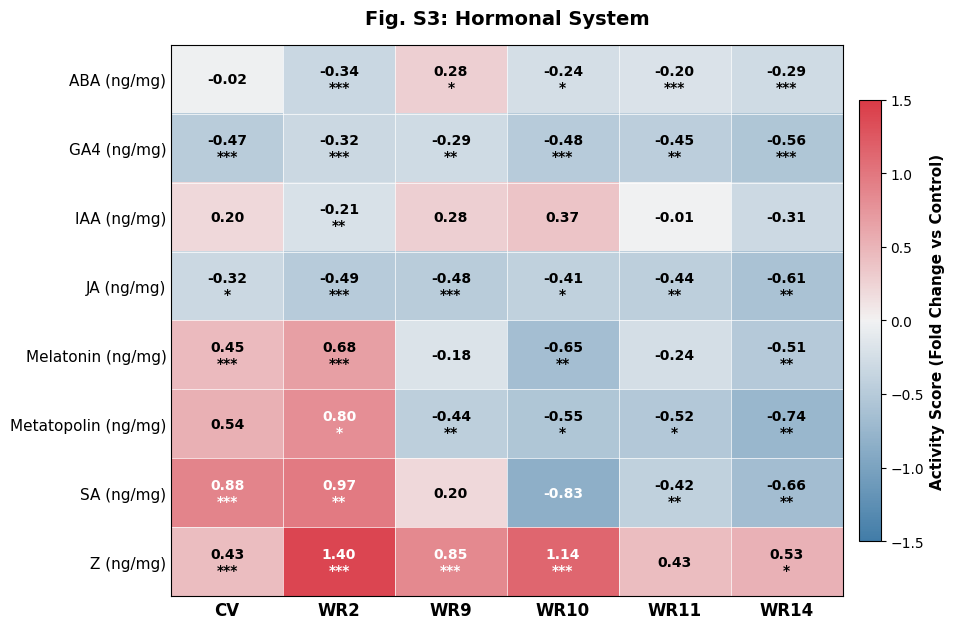

✅ Figure S3 saved!


In [15]:
S3_PARAMS = [
    'ABA (ng/mg)',
    'GA4 (ng/mg)',
    'IAA (ng/mg)',
    'JA (ng/mg)',
    'Melatonin (ng/mg)',
    'Metatopolin (ng/mg)',
    'SA (ng/mg)',
    'Z (ng/mg)'
]

data_S3, sig_S3 = create_heatmap_data(df_sm, S3_PARAMS)
fig_S3 = plot_sm_heatmap(data_S3, sig_S3, S3_PARAMS, 
                         'Fig. S3: Hormonal System',
                         vmin=-1.5, vmax=1.5, text_threshold=0.8)
plt.show()
fig_S3.savefig(sm_output_dir / 'figure_S3_hormonal.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Figure S3 saved!")

## Figure S4: Morphology and Growth

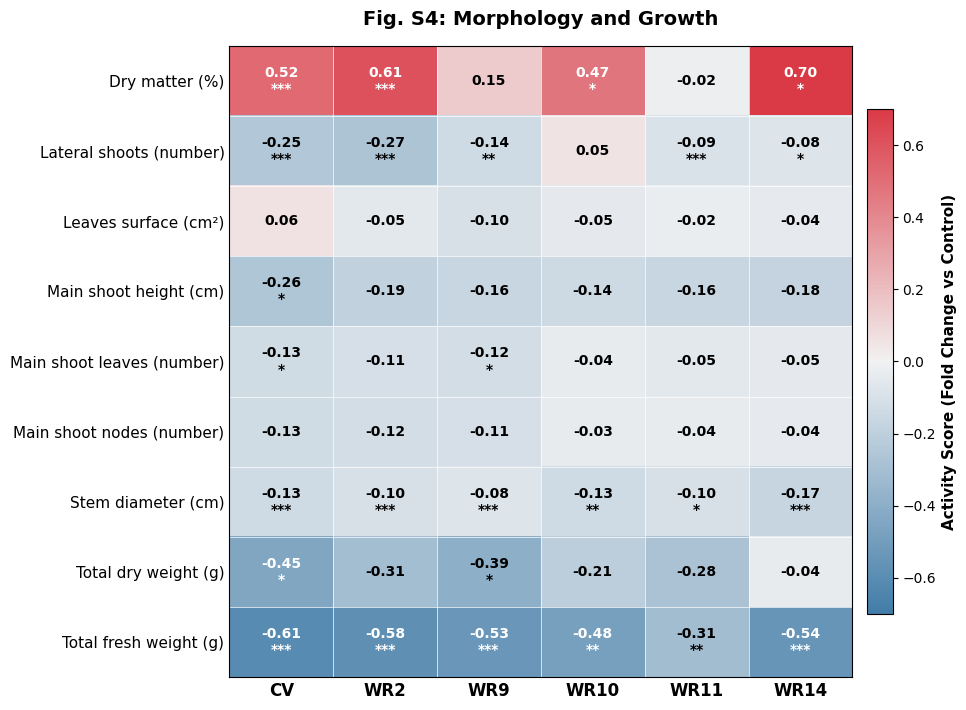

✅ Figure S4 saved!


In [16]:
S4_PARAMS = [
    'Dry matter (%)',
    'Lateral shoots (number)',
    'Leaves surface (cm²)',
    'Main shoot height (cm)',
    'Main shoot leaves (number)',
    'Main shoot nodes (number)',
    'Stem diameter (cm)',
    'Total dry weight (g)',
    'Total fresh weight (g)'
]

data_S4, sig_S4 = create_heatmap_data(df_sm, S4_PARAMS)
fig_S4 = plot_sm_heatmap(data_S4, sig_S4, S4_PARAMS, 
                         'Fig. S4: Morphology and Growth',
                         vmin=-0.7, vmax=0.7, text_threshold=0.4)
plt.show()
fig_S4.savefig(sm_output_dir / 'figure_S4_morphology.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Figure S4 saved!")

## Figure S5: Fruit Quality

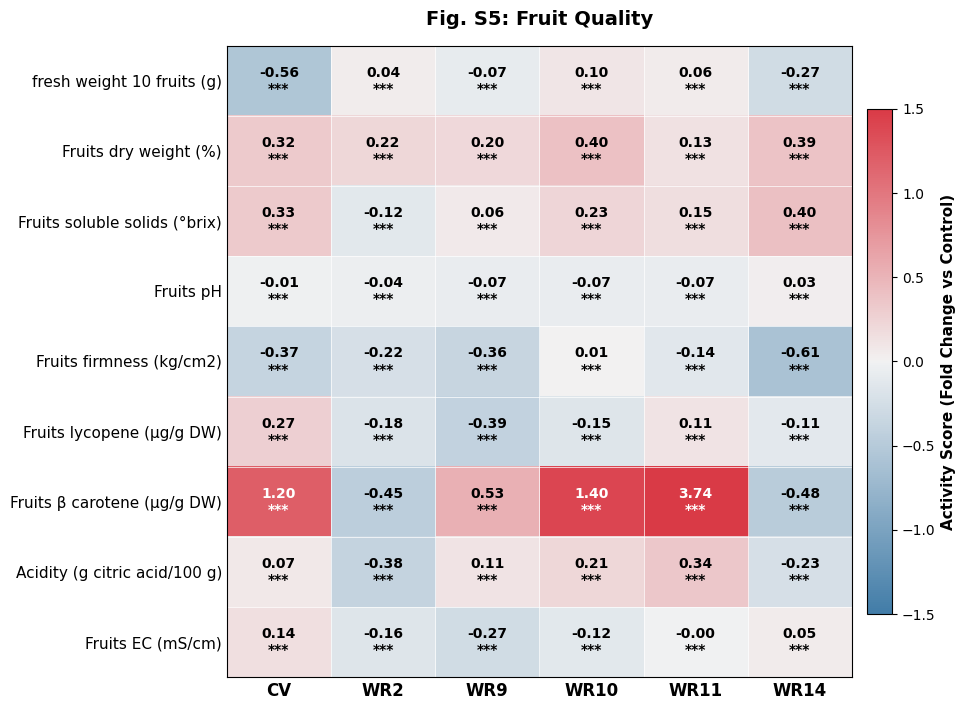

✅ Figure S5 saved!


In [17]:
S5_PARAMS = [
    'fresh weight 10 fruits (g)',
    'Fruits dry weight (%)',
    'Fruits soluble solids (°brix)',
    'Fruits pH',
    'Fruits firmness (kg/cm2)',
    'Fruits lycopene (μg/g DW)',
    'Fruits β carotene (μg/g DW)',
    'Acidity (g citric acid/100 g)',
    'Fruits EC (mS/cm)'
]

data_S5, sig_S5 = create_heatmap_data(df_sm, S5_PARAMS)
fig_S5 = plot_sm_heatmap(data_S5, sig_S5, S5_PARAMS, 
                         'Fig. S5: Fruit Quality',
                         vmin=-1.5, vmax=1.5, text_threshold=0.8)
plt.show()
fig_S5.savefig(sm_output_dir / 'figure_S5_fruit_quality.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Figure S5 saved!")

## Figure S6: Leaf Functionality

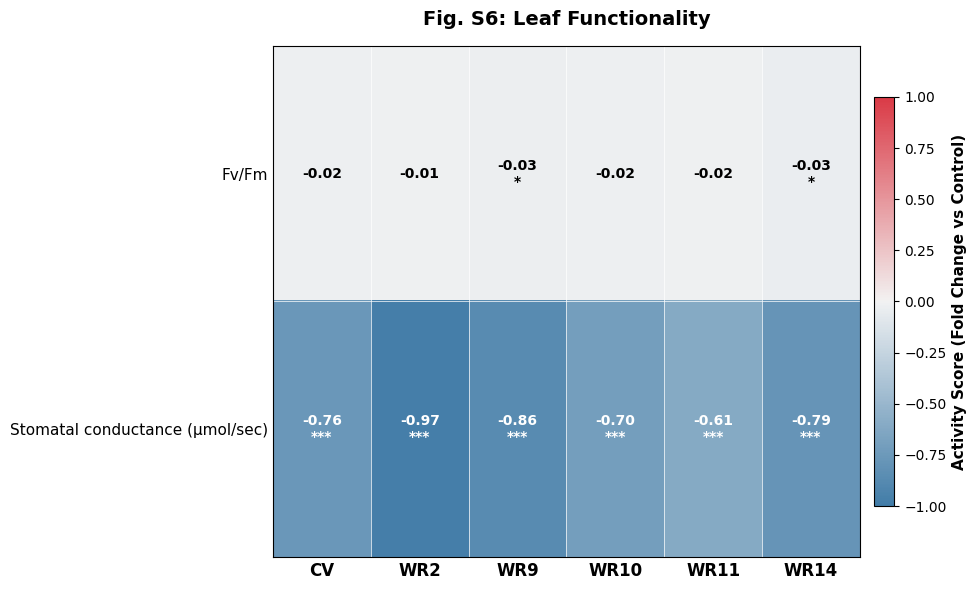

✅ Figure S6 saved!


In [18]:
S6_PARAMS = [
    'Fv/Fm',
    'Stomatal conductance (μmol/sec)'
]

data_S6, sig_S6 = create_heatmap_data(df_sm, S6_PARAMS)
fig_S6 = plot_sm_heatmap(data_S6, sig_S6, S6_PARAMS, 
                         'Fig. S6: Leaf Functionality',
                         vmin=-1.0, vmax=1.0, text_threshold=0.5)
plt.show()
fig_S6.savefig(sm_output_dir / 'figure_S6_leaf_functionality.png', 
               dpi=300, bbox_inches='tight', facecolor='white')
print("✅ Figure S6 saved!")

## Table S2: Parameter Scores for CV and WR10

Parameter scores for CV and WR10 across the three biological categories:
1. **Performance Maintenance** - Growth and yield-related parameters
2. **Physiological Stability** - Photosynthesis and water status parameters
3. **Stress Marker Response** - Stress indicator parameters

In [19]:
CATEGORIES = {
    'Performance Maintenance': [
        'Main shoot height (cm)',
        'Main shoot leaves (number)', 
        'Total dry weight (g)',
        'Total fresh weight (g)',
        'Fruit set (trusses number)',
        'Flowering (trusses number)'
    ],
    'Physiological Stability': [
        'Stomatal conductance (μmol/sec)',
        'Relative water content (%)',
        'Total chlorophyll (μg/g FW)',
        'Fv/Fm'
    ],
    'Stress Marker Response': [
        'Electrolytic leakage (μS/cm)',
        'Na/K ratio leaves',
        'ABA (ng/mg)',
        'Osmolytes (osm/kg)'
    ]
}

def calculate_parameter_score(df, param, variety):
    control = df[(df['Treatment'] == 'C') & (df['Variety'] == variety)][param].dropna()
    stress = df[(df['Treatment'] == 'S2') & (df['Variety'] == variety)][param].dropna()
    if len(control) < 2 or len(stress) < 2:
        return {'F': np.nan, 'eta_sq': np.nan, 'pct_change': np.nan}
    try:
        f_stat, p_val = stats.f_oneway(control, stress)
    except:
        f_stat = np.nan
    all_data = np.concatenate([control, stress])
    grand_mean = all_data.mean()
    ss_between = len(control) * (control.mean() - grand_mean)**2 + len(stress) * (stress.mean() - grand_mean)**2
    ss_total = np.sum((all_data - grand_mean)**2)
    eta_sq = ss_between / ss_total if ss_total > 0 else np.nan
    if control.mean() != 0:
        pct_change = abs((stress.mean() - control.mean()) / control.mean() * 100)
    else:
        pct_change = np.nan
    return {'F': f_stat, 'eta_sq': eta_sq * 100, 'pct_change': pct_change}

results = []
for category, params in CATEGORIES.items():
    for param in params:
        if param not in df_sm.columns:
            continue
        for variety in ['CV', 'WR10']:
            scores = calculate_parameter_score(df_sm, param, variety)
            results.append({
                'Category': category, 'Parameter': param, 'Variety': variety,
                'F-statistic': scores['F'], 'η² (%)': scores['eta_sq'], '% Change': scores['pct_change']
            })

table_s2 = pd.DataFrame(results)

# Display CV table
print("\n" + "="*80)
print("TABLE S2: Parameter Scores for CV and WR10")
print("="*80)
print("\n### CV (Domesticated Cultivar)")
cv_table = table_s2[table_s2['Variety'] == 'CV'].drop('Variety', axis=1).round(2)
display(cv_table)

print("\n### WR10 (Wild Relative - Most Tolerant)")
wr10_table = table_s2[table_s2['Variety'] == 'WR10'].drop('Variety', axis=1).round(2)
display(wr10_table)

# Save to CSV
csv_path = sm_output_dir / 'table_S2_parameter_scores.csv'
table_s2.to_csv(csv_path, index=False)
print(f"\n✅ Table S2 saved to: {csv_path}")


TABLE S2: Parameter Scores for CV and WR10

### CV (Domesticated Cultivar)


Category                        Parameter  F-statistic  \
0   Performance Maintenance           Main shoot height (cm)         5.50   
2   Performance Maintenance       Main shoot leaves (number)         4.84   
4   Performance Maintenance             Total dry weight (g)         7.08   
6   Performance Maintenance           Total fresh weight (g)        32.87   
8   Performance Maintenance       Fruit set (trusses number)         0.18   
10  Performance Maintenance       Flowering (trusses number)         1.25   
12  Physiological Stability  Stomatal conductance (μmol/sec)          inf   
14  Physiological Stability       Relative water content (%)          inf   
16  Physiological Stability      Total chlorophyll (μg/g FW)        22.63   
18  Physiological Stability                            Fv/Fm         2.27   
20   Stress Marker Response     Electrolytic leakage (μS/cm)       252.67   
22   Stress Marker Response                Na/K ratio leaves          inf   
24   Stress Marker Response                      ABA (ng/mg)         0.04   
26   Stress Marker Response               Osmolytes (osm/kg)         6.10   

    η² (%)  % Change  
0     4.72     26.22  
2     3.59     12.59  
4    17.23     44.84  
6    49.15     60.67  
8     0.14      7.87  
10    0.96     15.47  
12  100.00     75.78  
14  100.00     23.67  
16   39.96     37.60  
18    6.27      2.30  
20   88.14    116.30  
22  100.00   2536.73  
24    0.11      1.79  
26   15.22     26.71


### WR10 (Wild Relative - Most Tolerant)


Category                        Parameter  F-statistic  \
1   Performance Maintenance           Main shoot height (cm)         1.44   
3   Performance Maintenance       Main shoot leaves (number)         0.30   
5   Performance Maintenance             Total dry weight (g)         0.69   
7   Performance Maintenance           Total fresh weight (g)        18.25   
9   Performance Maintenance       Fruit set (trusses number)         0.47   
11  Performance Maintenance       Flowering (trusses number)         0.47   
13  Physiological Stability  Stomatal conductance (μmol/sec)          inf   
15  Physiological Stability       Relative water content (%)          inf   
17  Physiological Stability      Total chlorophyll (μg/g FW)         7.26   
19  Physiological Stability                            Fv/Fm         0.96   
21   Stress Marker Response     Electrolytic leakage (μS/cm)       603.14   
23   Stress Marker Response                Na/K ratio leaves          inf   
25   Stress Marker Response                      ABA (ng/mg)         7.57   
27   Stress Marker Response               Osmolytes (osm/kg)         3.43   

    η² (%)  % Change  
1     1.33     13.97  
3     0.25      3.73  
5     2.25     21.30  
7    37.83     48.33  
9     0.38     14.08  
11    0.38     10.02  
13  100.00     70.39  
15  100.00     56.34  
17   19.47     22.50  
19    3.10      1.96  
21   95.26    185.24  
23  100.00    891.43  
25   20.14     24.42  
27   10.25     11.77


✅ Table S2 saved to: /home/scatena/SRC/Tomato-Salt-Tolerance-Analysis/scripts/supplementary_figures/table_S2_parameter_scores.csv


---

## Complete Summary

All figures have been successfully generated:

### Manuscript Figures (1-8)
- ✅ Figure 1: Pathway Activity Heatmap
- ✅ Figure 2: Adaptive Differences (WR vs CV)
- ✅ Figure 3: Multilevel Correlation Network
- ✅ Figure 4: Phenological GDD Timing
- ✅ Figure 5: Temporal Dynamics
- ✅ Figure 6: Variety Ranking
- ✅ Figure 7: Parameter Responsiveness
- ✅ Figure 8: Regression Comparison

### Supplementary Materials
- ✅ Figure S1: Osmotic Regulation/Ionic Balance
- ✅ Figure S2: Primary/Secondary Metabolism
- ✅ Figure S3: Hormonal System
- ✅ Figure S4: Morphology and Growth
- ✅ Figure S5: Fruit Quality
- ✅ Figure S6: Leaf Functionality
- ✅ Table S2: Parameter Scores (CSV)

All output files are saved in the `scripts/` subdirectories.